In [1]:
# pip install tensorflow
# pip install scikit-posthocs
# pip install numpy==1.24.0

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# from mpl_toolkits.basemap import Basemap

# Filtragem do dataset

In [5]:
# dataset com todas as estações do Brasil
df_all = pd.read_csv('data/BrazilWeather/weather_sum_combinado.csv')

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858839 entries, 0 to 1858838
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ESTACAO            object 
 1   DATA (YYYY-MM-DD)  object 
 2   rain_max           float64
 3   rad_max            float64
 4   temp_avg           float64
 5   temp_max           float64
 6   temp_min           float64
 7   hum_max            float64
 8   hum_min            float64
 9   wind_max           float64
 10  wind_avg           float64
dtypes: float64(9), object(2)
memory usage: 156.0+ MB


Filtrando dados somente da cidade de Belém:

In [7]:
weather_df = df_all[df_all['ESTACAO'] == 'A201'].copy()

In [9]:
weather_df.head()

ESTACAO DATA (YYYY-MM-DD)  rain_max  rad_max   temp_avg  temp_max  \
83021    A201        2014-01-01       0.0   3245.0  27.458333      33.9   
83022    A201        2014-01-02       2.0   2734.1  27.654167      33.5   
83023    A201        2014-01-03       0.0   2998.8  27.670833      33.6   
83024    A201        2014-01-04       5.2   3171.7  26.179167      33.6   
83025    A201        2014-01-05      10.8   3015.3  26.191667      32.6   

       temp_min  hum_max  hum_min  wind_max  wind_avg  
83021      23.2     92.0     46.0       7.7  1.437500  
83022      24.8     87.0     51.0       6.5  1.041667  
83023      23.3     92.0     44.0       6.8  1.116667  
83024      23.7     93.0     49.0       6.1  0.975000  
83025      22.6     93.0     53.0       8.3  1.141667

# Pré-processamento

* Extrair características da data

In [11]:
weather_df['DATA (YYYY-MM-DD)'] = pd.to_datetime(weather_df['DATA (YYYY-MM-DD)'])

In [12]:
# Extrair características da data
weather_df.loc[:, 'ano'] = weather_df['DATA (YYYY-MM-DD)'].dt.year
weather_df.loc[:, 'mes'] = weather_df['DATA (YYYY-MM-DD)'].dt.month
weather_df.loc[:, 'dia'] = weather_df['DATA (YYYY-MM-DD)'].dt.day
# weather_df.loc[:, 'dia_da_semana'] = weather_df['DATA (YYYY-MM-DD)'].dt.dayofweek  # segunda = 0, domingo = 6


In [13]:
weather_df['ano'].value_counts()

ano
2016    366
2015    365
2018    365
2019    365
2023    365
2014    364
2017    364
2021    363
2022    356
2020    353
2024    244
Name: count, dtype: int64

In [14]:
weather_df['mes'].value_counts()

mes
5     341
7     341
8     341
1     340
4     329
3     327
6     321
2     311
10    310
12    310
11    300
9     299
Name: count, dtype: int64

* Verificar valores ausentes

In [15]:
print("Valores ausentes por coluna:")
print(weather_df.isnull().sum())

Valores ausentes por coluna:
ESTACAO               0
DATA (YYYY-MM-DD)     0
rain_max              0
rad_max              19
temp_avg              0
temp_max              0
temp_min              0
hum_max               0
hum_min               0
wind_max             74
wind_avg             74
ano                   0
mes                   0
dia                   0
dtype: int64


Interpolação

In [16]:
numeric_columns = weather_df.select_dtypes(include=['float64', 'int64'])
weather_df[numeric_columns.columns] = numeric_columns.interpolate(method='linear', inplace=False)

In [163]:
# # Calcular a matriz de correlação
# correlation_matrix = weather_df[['rain_max', 'rad_max', 'temp_avg', 'temp_max', 'temp_min', 'hum_max', 'hum_min', 'wind_max', 'wind_avg']].corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
# plt.show()

Temperatura Média (°C) por mês

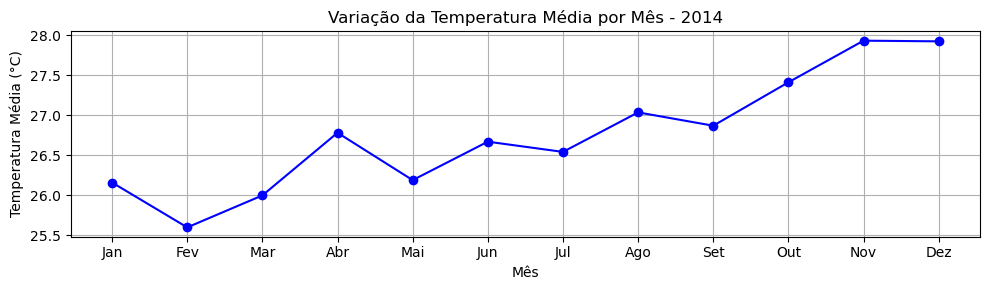

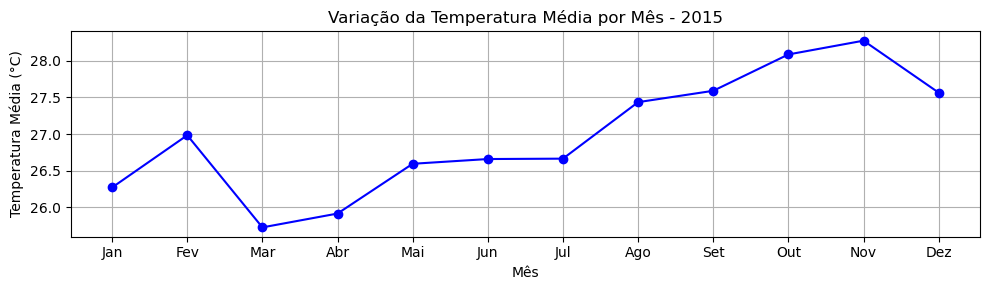

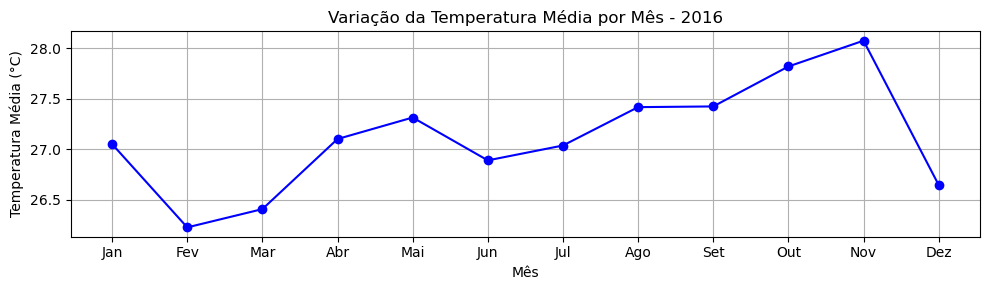

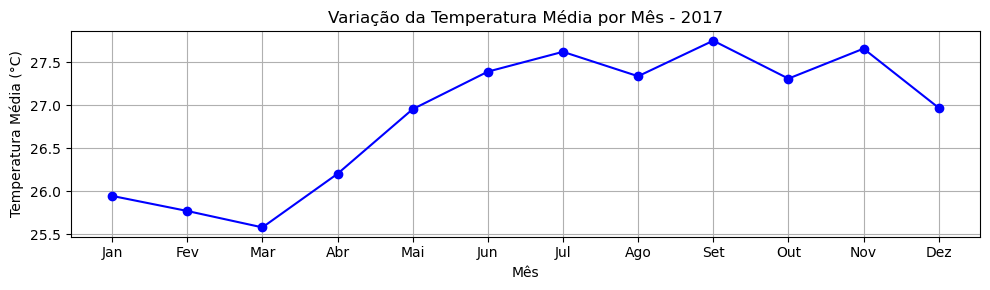

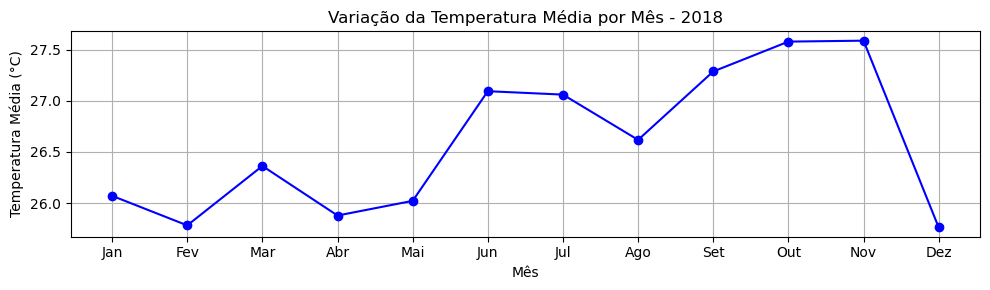

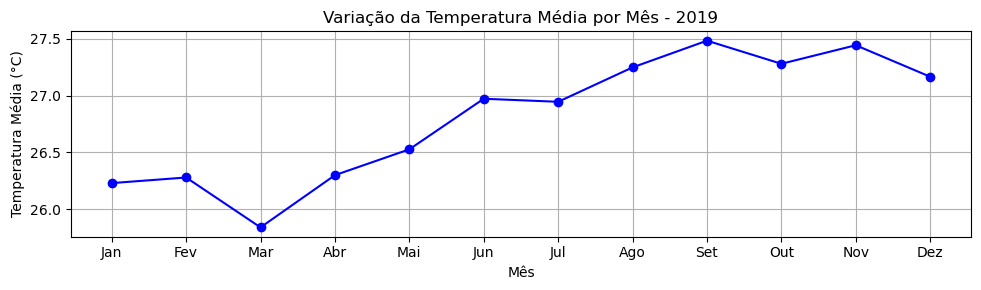

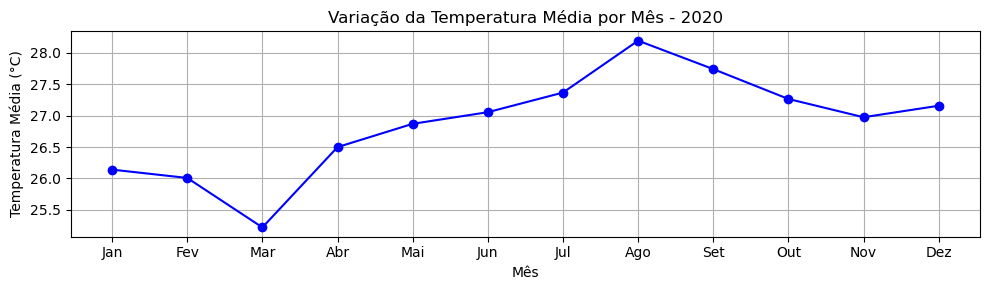

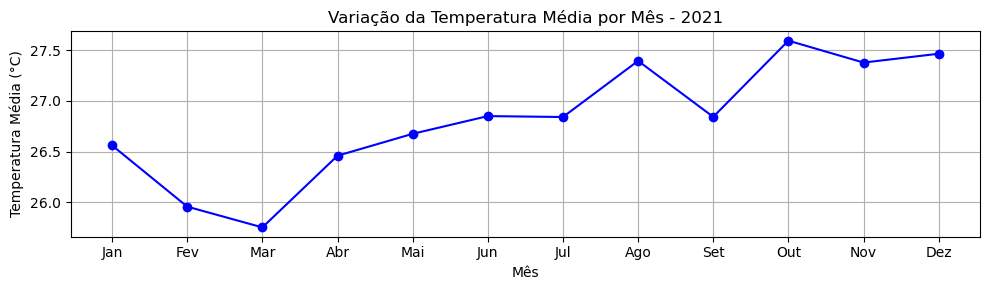

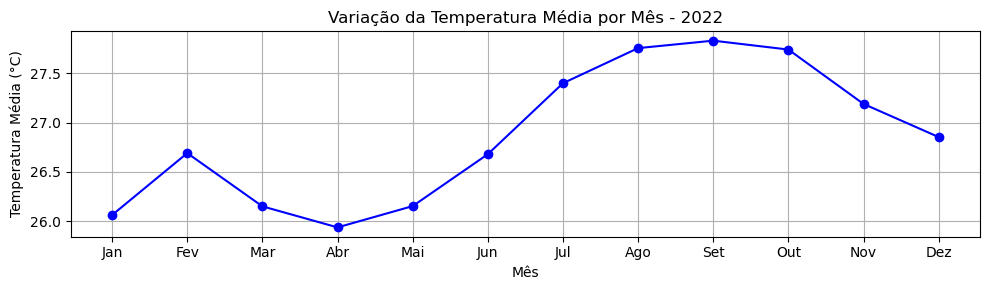

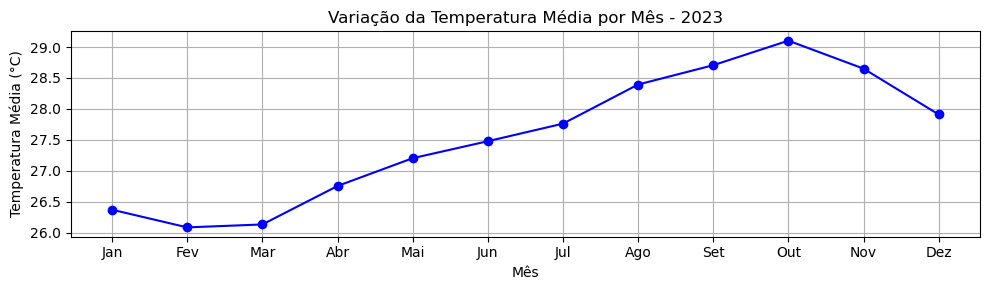

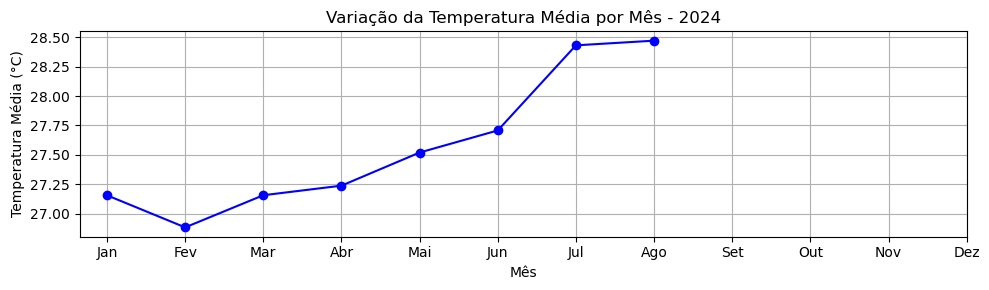

In [18]:
anos = weather_df['ano'].unique()
for ano in anos:
    plt.figure(figsize=(10, 3))
    dados_ano = weather_df[weather_df['ano'] == ano]
    dados_mes = dados_ano.groupby('mes')['temp_avg'].mean()
    
    plt.plot(dados_mes.index, dados_mes.values, label=f'Temperatura Média - {ano}', color='b', marker='o')
    plt.xlabel('Mês')
    plt.ylabel('Temperatura Média (°C)')
    plt.title(f'Variação da temperatura média por mês - {ano}')
    plt.grid(True)
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.tight_layout()
    plt.show()

## Seleção de variáveis

In [19]:
X_weather = weather_df[['rain_max', 'rad_max', 'temp_max', 'temp_min', 'hum_max', 'hum_min', 'wind_max', 'wind_avg', 'ano', 'mes']].values
y_weather = weather_df['temp_avg'].values

## Normalização

In [20]:
# Todas essas variáveis serão normalizadas para a mesma escala (média 0 e desvio padrão 1)
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

In [21]:
X_weather_scaled.shape

(3870, 10)

### Validação Cruzada

In [24]:
# tscv = TimeSeriesSplit(n_splits=5)

In [191]:
n_years = 10  # Número total de anos nos dados
n_splits = 5  # Número de divisões
test_size = 365  # Tamanho do conjunto de teste (1 ano)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

In [192]:
# Imprimir informações detalhadas sobre cada divisão
for fold, (train_index, test_index) in enumerate(tscv.split(weather_df)):
    train_start = weather_df['DATA (YYYY-MM-DD)'].iloc[train_index[0]]
    train_end = weather_df['DATA (YYYY-MM-DD)'].iloc[train_index[-1]]
    test_start = weather_df['DATA (YYYY-MM-DD)'].iloc[test_index[0]]
    test_end = weather_df['DATA (YYYY-MM-DD)'].iloc[test_index[-1]]
    
    print(f"\nDivisão {fold + 1}:")
    print(f"Treino: {train_start.date()} até {train_end.date()} ({len(train_index)} dias)")
    print(f"Teste:  {test_start.date()} até {test_end.date()} ({len(test_index)} dias)")


Divisão 1:
Treino: 2014-01-01 até 2019-08-09 (2045 dias)
Teste:  2019-08-10 até 2020-08-21 (365 dias)

Divisão 2:
Treino: 2014-01-01 até 2020-08-21 (2410 dias)
Teste:  2020-08-22 até 2021-08-22 (365 dias)

Divisão 3:
Treino: 2014-01-01 até 2021-08-22 (2775 dias)
Teste:  2021-08-23 até 2022-09-01 (365 dias)

Divisão 4:
Treino: 2014-01-01 até 2022-09-01 (3140 dias)
Teste:  2022-09-02 até 2023-09-01 (365 dias)

Divisão 5:
Treino: 2014-01-01 até 2023-09-01 (3505 dias)
Teste:  2023-09-02 até 2024-08-31 (365 dias)


# Arquiteturas 

In [22]:
def create_model1():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_weather_scaled.shape[1],)))  # Camada densa
    model.add(Dense(1))  # Saída linear para regressão
    return model

def create_model2():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_weather_scaled.shape[1],)))  # Primeira camada densa
    model.add(Dense(32, activation='relu'))  # Segunda camada densa
    model.add(Dense(1))  # Saída linear
    return model

def create_model3():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_weather_scaled.shape[1],)))  # Primeira camada densa
    model.add(Dense(32, activation='relu'))  # Segunda camada densa
    model.add(Dense(16, activation='relu'))  # Terceira camada densa
    model.add(Dense(1))  # Saída linear
    return model

## Otimizadores

In [23]:
# Definir as classes dos otimizadores (não as instâncias)
optimizers = {
    'Adam': (Adam, {'learning_rate': 0.001}),
    'RMSprop': (RMSprop, {'learning_rate': 0.001}),
    'SGD': (SGD, {'learning_rate': 0.001, 'momentum': 0.9}),
    'Adagrad': (Adagrad, {'learning_rate': 0.001})
}

In [28]:
# Dicionário para armazenar os resultados e previsões
results = {model_name: {opt_name: {'MAE': [], 'MSE': [], 'RMSE': [], 'predictions': []} 
                        for opt_name in optimizers.keys()} 
           for model_name in ['model1', 'model2', 'model3']}

# Treinamento

In [30]:
# Loop de treinamento corrigido
for optimizer_name, (optimizer_class, optimizer_params) in optimizers.items():
    print(f"Treinando com {optimizer_name}")

    for train_index, val_index in tscv.split(X_weather_scaled):
        X_train, X_val = X_weather_scaled[train_index], X_weather_scaled[val_index]
        y_train, y_val = y_weather[train_index], y_weather[val_index]

        for idx, create_model in enumerate([create_model1, create_model2, create_model3]):
            print(f"Treinando Arquitetura {idx + 1} com {optimizer_name}")
            model = create_model()
            # Criar uma nova instância do otimizador para cada modelo
            optimizer = optimizer_class(**optimizer_params)
            
            model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
            history = model.fit(X_train, y_train, 
                              epochs=100,
                              batch_size=64, 
                              verbose=1, 
                              validation_data=(X_val, y_val))

            y_pred = model.predict(X_val).flatten()

            mae = mean_absolute_error(y_val, y_pred)
            mse = mean_squared_error(y_val, y_pred)
            rmse = np.sqrt(mse)

            model_name = f"model{idx + 1}"
            results[model_name][optimizer_name]['MAE'].append(mae)
            results[model_name][optimizer_name]['MSE'].append(mse)
            results[model_name][optimizer_name]['RMSE'].append(rmse)
            results[model_name][optimizer_name]['predictions'].append((y_val, y_pred))
            results[model_name][optimizer_name]['history'] = history.history

            print(f"\nFold Resultados ({optimizer_name} - Arquitetura {idx + 1}):")
            print(f"MAE: {mae:.4f}")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")

Treinando com Adam
Treinando Arquitetura 1 com Adam


C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 721.7504 - mae: 26.8495 - mse: 721.7504 - val_loss: 688.8683 - val_mae: 26.1955 - val_mse: 688.8683
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 665.7772 - mae: 25.7844 - mse: 665.7772 - val_loss: 639.5299 - val_mae: 25.2244 - val_mse: 639.5299
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 601.7493 - mae: 24.5006 - mse: 601.7493 - val_loss: 581.9293 - val_mae: 24.0526 - val_mse: 581.9293
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 527.9206 - mae: 22.9155 - mse: 527.9206 - val_loss: 516.4313 - val_mae: 22.6238 - val_mse: 516.4313
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 440.8172 - mae: 20.8563 - mse: 440.8172 - val_loss: 448.8066 - val_mae: 20.9369 - val_mse: 448.8066
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 346.1507 - mae: 18.3233 - mse: 346.1507 - val_loss: 384.6967 - val_mae: 19.0331 - val_mse: 384.6967
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 658.8323 - mae: 25.6339 - mse: 658.8323 - val_loss: 564.2704 - val_mae: 23.6852 - val_mse: 564.2704
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 492.4256 - mae: 22.0682 - mse: 492.4256 - val_loss: 366.3024 - val_mae: 18.4602 - val_mse: 366.3024
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 234.5693 - mae: 14.6106 - mse: 234.5693 - val_loss: 249.4825 - val_mae: 11.7877 - val_mse: 249.4825
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.8219 - mae: 7.5583 - mse: 79.8219 - val_loss: 262.7728 - val_mae: 9.9180 - val_mse: 262.7728
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.9760 - mae: 5.8276 - mse: 52.9760 - val_loss: 241.8691 - val_mae: 9.5308 - val_mse: 241.8691
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.0464 - mae: 5.2892 - mse: 42.0464 - val_loss: 228.7222 - val_mae: 9.1741 - val_mse: 228.7222
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.3477 - m

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 687.6037 - mae: 26.1914 - mse: 687.6037 - val_loss: 546.4608 - val_mae: 23.2837 - val_mse: 546.4608
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 419.1614 - mae: 20.1759 - mse: 419.1614 - val_loss: 297.5656 - val_mae: 13.7567 - val_mse: 297.5656
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82.2262 - mae: 7.8071 - mse: 82.2262 - val_loss: 290.4822 - val_mae: 9.5921 - val_mse: 290.4822
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.4200 - mae: 5.4722 - mse: 46.4200 - val_loss: 245.2840 - val_mae: 9.2672 - val_mse: 245.2840
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.2049 - mae: 4.8208 - mse: 36.2049 - val_loss: 220.3479 - val_mae: 8.8179 - val_mse: 220.3479
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 30.4101 - mae: 4.4170 - mse: 30.4101 - val_loss: 202.7554 - val_mae: 8.1084 - val_mse: 202.7554
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.0587 - mae:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 709.7130 - mae: 26.6196 - mse: 709.7130 - val_loss: 675.3801 - val_mae: 25.9718 - val_mse: 675.3801
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 647.8101 - mae: 25.4285 - mse: 647.8101 - val_loss: 629.6897 - val_mae: 25.0672 - val_mse: 629.6897
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 575.4015 - mae: 23.9430 - mse: 575.4015 - val_loss: 576.2553 - val_mae: 23.9491 - val_mse: 576.2553
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 486.0656 - mae: 21.9743 - mse: 486.0656 - val_loss: 515.6426 - val_mae: 22.5769 - val_mse: 515.6426
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 383.7195 - mae: 19.4098 - mse: 383.7195 - val_loss: 451.9884 - val_mae: 20.9713 - val_mse: 451.9884
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.8090 - mae: 16.3874 - mse: 282.8090 - val_loss: 393.2020 - val_mae: 19.2771 - val_mse: 393.2020
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 687.3831 - mae: 26.1924 - mse: 687.3831 - val_loss: 614.7291 - val_mae: 24.7625 - val_mse: 614.7291
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 525.7205 - mae: 22.8488 - mse: 525.7205 - val_loss: 419.2376 - val_mae: 20.2733 - val_mse: 419.2376
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257.5156 - mae: 15.3597 - mse: 257.5156 - val_loss: 214.1220 - val_mae: 13.5364 - val_mse: 214.1220
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.1669 - mae: 7.2850 - mse: 81.1669 - val_loss: 156.1878 - val_mae: 11.2468 - val_mse: 156.1878
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.6796 - mae: 6.0099 - mse: 57.6796 - val_loss: 137.3343 - val_mae: 10.6046 - val_mse: 137.3343
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.6786 - mae: 5.5004 - mse: 48.6786 - val_loss: 112.3377 - val_mae: 9.5869 - val_mse: 112.3377
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.4522 -

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 729.7429 - mae: 26.9957 - mse: 729.7429 - val_loss: 706.1981 - val_mae: 26.5585 - val_mse: 706.1981
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 687.9525 - mae: 26.2041 - mse: 687.9525 - val_loss: 615.2864 - val_mae: 24.7779 - val_mse: 615.2864
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 511.0390 - mae: 22.4500 - mse: 511.0390 - val_loss: 338.8273 - val_mae: 17.9541 - val_mse: 338.8273
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151.7355 - mae: 10.8731 - mse: 151.7355 - val_loss: 162.2490 - val_mae: 11.4849 - val_mse: 162.2490
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91.6926 - mae: 6.4520 - mse: 91.6926 - val_loss: 136.7529 - val_mae: 10.4642 - val_mse: 136.7529
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.4825 - mae: 5.2491 - mse: 54.4825 - val_loss: 111.4791 - val_mae: 9.3834 - val_mse: 111.4791
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.499

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 706.8674 - mae: 26.5642 - mse: 706.8674 - val_loss: 663.1995 - val_mae: 25.7233 - val_mse: 663.1995
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 631.5038 - mae: 25.1040 - mse: 631.5038 - val_loss: 607.1846 - val_mae: 24.5808 - val_mse: 607.1846
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 543.4325 - mae: 23.2504 - mse: 543.4325 - val_loss: 543.9339 - val_mae: 23.1864 - val_mse: 543.9339
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 439.0594 - mae: 20.7819 - mse: 439.0594 - val_loss: 476.8833 - val_mae: 21.5550 - val_mse: 476.8833
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 324.6107 - mae: 17.5862 - mse: 324.6107 - val_loss: 413.5102 - val_mae: 19.8629 - val_mse: 413.5102
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 227.6040 - mae: 14.2759 - mse: 227.6040 - val_loss: 360.1081 - val_mae: 18.3490 - val_mse: 360.1081
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 700.3663 - mae: 26.4161 - mse: 700.3663 - val_loss: 589.1830 - val_mae: 24.1834 - val_mse: 589.1830
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 478.1764 - mae: 21.6658 - mse: 478.1764 - val_loss: 378.0029 - val_mae: 19.0087 - val_mse: 378.0029
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197.0324 - mae: 12.6965 - mse: 197.0324 - val_loss: 226.6426 - val_mae: 14.1335 - val_mse: 226.6426
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.5694 - mae: 7.6001 - mse: 99.5694 - val_loss: 177.4321 - val_mae: 12.3384 - val_mse: 177.4321
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.1266 - mae: 6.6326 - mse: 78.1266 - val_loss: 139.0437 - val_mae: 10.7906 - val_mse: 139.0437
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.5534 - mae: 5.7923 - mse: 61.5534 - val_loss: 101.9816 - val_mae: 9.0603 - val_mse: 101.9816
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.7527 -

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 675.6343 - mae: 25.9526 - mse: 675.6343 - val_loss: 535.7252 - val_mae: 23.0650 - val_mse: 535.7252
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 386.0139 - mae: 19.0894 - mse: 386.0139 - val_loss: 163.7138 - val_mae: 11.8477 - val_mse: 163.7138
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.8051 - mae: 7.1360 - mse: 80.8051 - val_loss: 99.7401 - val_mae: 8.7965 - val_mse: 99.7401
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.5593 - mae: 5.7868 - mse: 64.5593 - val_loss: 64.4276 - val_mae: 6.7753 - val_mse: 64.4276
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.3293 - mae: 4.8658 - mse: 37.3293 - val_loss: 42.6341 - val_mae: 5.3461 - val_mse: 42.6341
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.8001 - mae: 4.4330 - mse: 35.8001 - val_loss: 32.6414 - val_mae: 4.6693 - val_mse: 32.6414
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.6404 - mae: 3.8879 -

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 692.9705 - mae: 26.2986 - mse: 692.9705 - val_loss: 669.0953 - val_mae: 25.8346 - val_mse: 669.0953
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 611.8076 - mae: 24.6914 - mse: 611.8076 - val_loss: 595.9163 - val_mae: 24.3516 - val_mse: 595.9163
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 512.2084 - mae: 22.5443 - mse: 512.2084 - val_loss: 518.3077 - val_mae: 22.6380 - val_mse: 518.3077
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 399.6659 - mae: 19.7492 - mse: 399.6659 - val_loss: 437.2600 - val_mae: 20.6301 - val_mse: 437.2600
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 287.2901 - mae: 16.3385 - mse: 287.2901 - val_loss: 358.6868 - val_mae: 18.3940 - val_mse: 358.6868
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206.9891 - mae: 13.2184 - mse: 206.9891 - val_loss: 290.2949 - val_mae: 16.3064 - val_mse: 290.2949
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 660.1965 - mae: 25.6390 - mse: 660.1965 - val_loss: 513.8975 - val_mae: 22.5151 - val_mse: 513.8975
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 405.6408 - mae: 19.7115 - mse: 405.6408 - val_loss: 238.3248 - val_mae: 14.6443 - val_mse: 238.3248
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3815 - mae: 9.0592 - mse: 119.3815 - val_loss: 101.5990 - val_mae: 8.9933 - val_mse: 101.5990
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.6813 - mae: 5.9562 - mse: 57.6813 - val_loss: 52.3136 - val_mae: 6.2359 - val_mse: 52.3136
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.7831 - mae: 5.1323 - mse: 48.7831 - val_loss: 27.8621 - val_mae: 4.4039 - val_mse: 27.8621
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.3615 - mae: 4.3470 - mse: 33.3615 - val_loss: 17.9495 - val_mae: 3.4246 - val_mse: 17.9495
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.6171 - mae: 3.93

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 683.5748 - mae: 26.0924 - mse: 683.5748 - val_loss: 501.1034 - val_mae: 22.0305 - val_mse: 501.1034
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 331.5620 - mae: 17.0823 - mse: 331.5620 - val_loss: 111.1176 - val_mae: 9.3231 - val_mse: 111.1176
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.3505 - mae: 6.0662 - mse: 70.3505 - val_loss: 41.8298 - val_mae: 5.2597 - val_mse: 41.8298
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.6953 - mae: 5.1328 - mse: 64.6953 - val_loss: 26.3974 - val_mae: 3.9782 - val_mse: 26.3974
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.4959 - mae: 4.2240 - mse: 35.4959 - val_loss: 19.2607 - val_mae: 3.3790 - val_mse: 19.2607
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.4220 - mae: 3.7972 - mse: 31.4220 - val_loss: 16.9183 - val_mae: 3.0890 - val_mse: 16.9183
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0945 - mae: 3.6155 - 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 734.6333 - mae: 27.0777 - mse: 734.6333 - val_loss: 746.8728 - val_mae: 27.3091 - val_mse: 746.8728
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 653.0533 - mae: 25.4966 - mse: 653.0533 - val_loss: 662.3856 - val_mae: 25.7099 - val_mse: 662.3856
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 561.2375 - mae: 23.6118 - mse: 561.2375 - val_loss: 565.7084 - val_mae: 23.7228 - val_mse: 565.7084
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 454.1915 - mae: 21.1347 - mse: 454.1915 - val_loss: 460.3265 - val_mae: 21.2758 - val_mse: 460.3265
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 344.2543 - mae: 18.1220 - mse: 344.2543 - val_loss: 352.7417 - val_mae: 18.3252 - val_mse: 352.7417
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 242.8407 - mae: 14.7936 - mse: 242.8407 - val_loss: 260.0823 - val_mae: 15.2243 - val_mse: 260.0823
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 658.0364 - mae: 25.6035 - mse: 658.0364 - val_loss: 438.1311 - val_mae: 20.8294 - val_mse: 438.1311
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 335.3653 - mae: 17.6922 - mse: 335.3653 - val_loss: 72.0205 - val_mae: 7.5707 - val_mse: 72.0205
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.1630 - mae: 7.0101 - mse: 72.1630 - val_loss: 34.3036 - val_mae: 4.4385 - val_mse: 34.3036
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.6771 - mae: 5.1920 - mse: 42.6771 - val_loss: 29.5962 - val_mae: 4.2422 - val_mse: 29.5962
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.0196 - mae: 4.6539 - mse: 41.0196 - val_loss: 29.3519 - val_mae: 4.2599 - val_mse: 29.3519
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.1712 - mae: 4.0405 - mse: 30.1712 - val_loss: 27.3435 - val_mae: 4.2010 - val_mse: 27.3435
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1240 - mae: 3.5229 - ms

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 674.1473 - mae: 25.9025 - mse: 674.1473 - val_loss: 388.5683 - val_mae: 19.5432 - val_mse: 388.5683
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 272.3075 - mae: 15.1659 - mse: 272.3075 - val_loss: 71.4505 - val_mae: 6.2602 - val_mse: 71.4505
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66.4701 - mae: 5.7548 - mse: 66.4701 - val_loss: 42.6359 - val_mae: 4.9854 - val_mse: 42.6359
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.4979 - mae: 4.4050 - mse: 34.4979 - val_loss: 31.4882 - val_mae: 4.4093 - val_mse: 31.4882
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.4049 - mae: 3.8839 - mse: 28.4049 - val_loss: 28.3061 - val_mae: 4.3407 - val_mse: 28.3061
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2307 - mae: 3.7095 - mse: 34.2307 - val_loss: 27.4077 - val_mae: 4.3962 - val_mse: 27.4077
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.6531 - mae: 3.2754 - ms

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 694.8304 - mae: 26.3310 - mse: 694.8304 - val_loss: 666.9797 - val_mae: 25.7502 - val_mse: 666.9797
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 631.9570 - mae: 25.1092 - mse: 631.9570 - val_loss: 615.4431 - val_mae: 24.7355 - val_mse: 615.4431
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 568.9748 - mae: 23.8123 - mse: 568.9748 - val_loss: 562.8420 - val_mae: 23.6570 - val_mse: 562.8420
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 509.2841 - mae: 22.5127 - mse: 509.2841 - val_loss: 508.8526 - val_mae: 22.4582 - val_mse: 508.8526
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 435.7521 - mae: 20.7729 - mse: 435.7521 - val_loss: 453.8708 - val_mae: 21.1145 - val_mse: 453.8708
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 369.6216 - mae: 19.0584 - mse: 369.6216 - val_loss: 399.7454 - val_mae: 19.6215 - val_mse: 399.7454
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 676.3493 - mae: 25.9648 - mse: 676.3493 - val_loss: 560.5030 - val_mae: 23.5972 - val_mse: 560.5030
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 486.3428 - mae: 21.9203 - mse: 486.3428 - val_loss: 385.7069 - val_mae: 18.8570 - val_mse: 385.7069
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 260.4843 - mae: 15.6074 - mse: 260.4843 - val_loss: 274.7312 - val_mae: 13.0710 - val_mse: 274.7312
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.7979 - mae: 8.9097 - mse: 103.7979 - val_loss: 262.3146 - val_mae: 10.1393 - val_mse: 262.3146
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.9026 - mae: 5.9660 - mse: 53.9026 - val_loss: 243.9188 - val_mae: 9.5211 - val_mse: 243.9188
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.1206 - mae: 5.0517 - mse: 41.1206 - val_loss: 209.1414 - val_mae: 8.7936 - val_mse: 209.1414
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.4421 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 694.6829 - mae: 26.3302 - mse: 694.6829 - val_loss: 579.9930 - val_mae: 24.0082 - val_mse: 579.9930
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 500.1430 - mae: 22.2455 - mse: 500.1430 - val_loss: 354.2769 - val_mae: 18.1464 - val_mse: 354.2769
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 230.2792 - mae: 14.5115 - mse: 230.2792 - val_loss: 229.8500 - val_mae: 11.2651 - val_mse: 229.8500
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.4871 - mae: 6.9456 - mse: 67.4871 - val_loss: 233.0017 - val_mae: 9.2157 - val_mse: 233.0017
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.9620 - mae: 5.3017 - mse: 43.9620 - val_loss: 202.6187 - val_mae: 8.5201 - val_mse: 202.6187
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.4654 - mae: 4.4581 - mse: 31.4654 - val_loss: 178.2197 - val_mae: 7.8983 - val_mse: 178.2197
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.0258 - m

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 708.7112 - mae: 26.5928 - mse: 708.7112 - val_loss: 674.2263 - val_mae: 25.9356 - val_mse: 674.2263
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 650.4008 - mae: 25.4650 - mse: 650.4008 - val_loss: 629.9801 - val_mae: 25.0529 - val_mse: 629.9801
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 588.6414 - mae: 24.2110 - mse: 588.6414 - val_loss: 582.3571 - val_mae: 24.0581 - val_mse: 582.3571
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 520.3173 - mae: 22.7346 - mse: 520.3173 - val_loss: 531.7796 - val_mae: 22.9371 - val_mse: 531.7796
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 444.2613 - mae: 20.9282 - mse: 444.2613 - val_loss: 479.0997 - val_mae: 21.6794 - val_mse: 479.0997
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 363.5678 - mae: 18.7918 - mse: 363.5678 - val_loss: 426.3855 - val_mae: 20.2953 - val_mse: 426.3855
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 670.1446 - mae: 25.8366 - mse: 670.1446 - val_loss: 580.4465 - val_mae: 24.0454 - val_mse: 580.4465
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 448.7679 - mae: 21.0373 - mse: 448.7679 - val_loss: 411.6333 - val_mae: 20.0229 - val_mse: 411.6333
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 212.6838 - mae: 13.6773 - mse: 212.6838 - val_loss: 261.0094 - val_mae: 15.2579 - val_mse: 261.0094
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.3593 - mae: 7.3494 - mse: 80.3593 - val_loss: 194.8143 - val_mae: 12.8443 - val_mse: 194.8143
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.7036 - mae: 5.9830 - mse: 56.7036 - val_loss: 151.3744 - val_mae: 11.1733 - val_mse: 151.3744
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.7297 - mae: 5.2186 - mse: 45.7297 - val_loss: 114.8158 - val_mae: 9.6449 - val_mse: 114.8158
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.0124 -

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 673.8776 - mae: 25.9097 - mse: 673.8776 - val_loss: 507.6843 - val_mae: 22.4607 - val_mse: 507.6843
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 372.1285 - mae: 18.8445 - mse: 372.1285 - val_loss: 201.4286 - val_mae: 13.3403 - val_mse: 201.4286
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 112.7447 - mae: 8.3129 - mse: 112.7447 - val_loss: 114.0824 - val_mae: 9.6577 - val_mse: 114.0824
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.3034 - mae: 5.4112 - mse: 70.3034 - val_loss: 86.2136 - val_mae: 8.3452 - val_mse: 86.2136
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.1385 - mae: 4.6287 - mse: 43.1385 - val_loss: 62.1837 - val_mae: 7.0284 - val_mse: 62.1837
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.4553 - mae: 4.0180 - mse: 35.4553 - val_loss: 44.5091 - val_mae: 5.9002 - val_mse: 44.5091
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3511

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 687.5675 - mae: 26.1899 - mse: 687.5675 - val_loss: 654.9968 - val_mae: 25.5453 - val_mse: 654.9968
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 603.4971 - mae: 24.5129 - mse: 603.4971 - val_loss: 608.7345 - val_mae: 24.5880 - val_mse: 608.7345
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 523.5046 - mae: 22.7816 - mse: 523.5046 - val_loss: 560.5788 - val_mae: 23.5285 - val_mse: 560.5788
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 435.3675 - mae: 20.6840 - mse: 435.3675 - val_loss: 511.8969 - val_mae: 22.3757 - val_mse: 511.8969
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 346.3412 - mae: 18.2441 - mse: 346.3412 - val_loss: 464.0907 - val_mae: 21.1854 - val_mse: 464.0907
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 266.3285 - mae: 15.7018 - mse: 266.3285 - val_loss: 418.3181 - val_mae: 19.9724 - val_mse: 418.3181
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 699.6552 - mae: 26.4191 - mse: 699.6552 - val_loss: 597.4576 - val_mae: 24.4030 - val_mse: 597.4576
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 521.9222 - mae: 22.7468 - mse: 521.9222 - val_loss: 420.2913 - val_mae: 20.2661 - val_mse: 420.2913
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 277.5074 - mae: 16.0327 - mse: 277.5074 - val_loss: 253.8456 - val_mae: 15.1853 - val_mse: 253.8456
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.5861 - mae: 9.1075 - mse: 116.5861 - val_loss: 156.4314 - val_mae: 11.5371 - val_mse: 156.4314
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.4109 - mae: 6.7435 - mse: 76.4109 - val_loss: 99.0629 - val_mae: 9.0100 - val_mse: 99.0629
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.8419 - mae: 5.6821 - mse: 58.8419 - val_loss: 55.5150 - val_mae: 6.6004 - val_mse: 55.5150
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.7965 - ma

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 640.4220 - mae: 25.2243 - mse: 640.4220 - val_loss: 389.4760 - val_mae: 19.5692 - val_mse: 389.4760
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 243.0502 - mae: 14.7125 - mse: 243.0502 - val_loss: 109.9722 - val_mae: 9.4564 - val_mse: 109.9722
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.3432 - mae: 5.9776 - mse: 65.3432 - val_loss: 51.2705 - val_mae: 5.9962 - val_mse: 51.2705
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.8448 - mae: 4.7981 - mse: 39.8448 - val_loss: 28.0443 - val_mae: 4.3106 - val_mse: 28.0443
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.3960 - mae: 3.9810 - mse: 26.3960 - val_loss: 17.2046 - val_mae: 3.2114 - val_mse: 17.2046
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4978 - mae: 3.3805 - mse: 22.4978 - val_loss: 12.8617 - val_mae: 2.7499 - val_mse: 12.8617
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.6998 - mae: 2.8531 - 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 695.0763 - mae: 26.3173 - mse: 695.0763 - val_loss: 662.1857 - val_mae: 25.6430 - val_mse: 662.1857
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 605.1637 - mae: 24.5158 - mse: 605.1637 - val_loss: 596.3648 - val_mae: 24.2563 - val_mse: 596.3648
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 516.1448 - mae: 22.5611 - mse: 516.1448 - val_loss: 533.1690 - val_mae: 22.7793 - val_mse: 533.1690
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 426.5263 - mae: 20.3536 - mse: 426.5263 - val_loss: 473.2314 - val_mae: 21.1941 - val_mse: 473.2314
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 334.6317 - mae: 17.7056 - mse: 334.6317 - val_loss: 414.4731 - val_mae: 19.6618 - val_mse: 414.4731
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 246.6177 - mae: 14.8919 - mse: 246.6177 - val_loss: 358.3343 - val_mae: 18.0898 - val_mse: 358.3343
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 631.3370 - mae: 25.0523 - mse: 631.3370 - val_loss: 453.1409 - val_mae: 21.0996 - val_mse: 453.1409
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 327.8863 - mae: 17.5535 - mse: 327.8863 - val_loss: 206.3166 - val_mae: 13.5720 - val_mse: 206.3166
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.5852 - mae: 9.0471 - mse: 113.5852 - val_loss: 80.1457 - val_mae: 7.7717 - val_mse: 80.1457
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.3904 - mae: 6.2684 - mse: 61.3904 - val_loss: 34.8020 - val_mae: 4.8240 - val_mse: 34.8020
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.6532 - mae: 5.0400 - mse: 55.6532 - val_loss: 23.3878 - val_mae: 3.6119 - val_mse: 23.3878
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.5412 - mae: 3.9061 - mse: 26.5412 - val_loss: 14.9705 - val_mae: 2.8531 - val_mse: 14.9705
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2646 - mae: 3.1886

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 591.0219 - mae: 24.1179 - mse: 591.0219 - val_loss: 297.0741 - val_mae: 16.7392 - val_mse: 297.0741
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 148.5481 - mae: 10.4902 - mse: 148.5481 - val_loss: 62.1670 - val_mae: 6.8561 - val_mse: 62.1670
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.0159 - mae: 6.0341 - mse: 87.0159 - val_loss: 24.2703 - val_mae: 3.7314 - val_mse: 24.2703
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.4501 - mae: 4.5721 - mse: 46.4501 - val_loss: 14.6591 - val_mae: 2.7797 - val_mse: 14.6591
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.7517 - mae: 3.7391 - mse: 40.7517 - val_loss: 17.8465 - val_mae: 3.2449 - val_mse: 17.8465
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0972 - mae: 3.0208 - mse: 19.0972 - val_loss: 13.2417 - val_mae: 2.8813 - val_mse: 13.2417
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5000 - mae: 2.5211 - ms

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 671.6819 - mae: 25.8878 - mse: 671.6819 - val_loss: 653.7997 - val_mae: 25.5478 - val_mse: 653.7997
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 578.1296 - mae: 23.9924 - mse: 578.1296 - val_loss: 551.0588 - val_mae: 23.4309 - val_mse: 551.0588
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 478.6516 - mae: 21.7586 - mse: 478.6516 - val_loss: 447.0220 - val_mae: 21.0303 - val_mse: 447.0220
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 374.7521 - mae: 19.0787 - mse: 374.7521 - val_loss: 343.2139 - val_mae: 18.2462 - val_mse: 343.2139
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.9540 - mae: 16.0407 - mse: 273.9540 - val_loss: 244.3627 - val_mae: 15.0202 - val_mse: 244.3627
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183.3729 - mae: 12.6937 - mse: 183.3729 - val_loss: 157.6974 - val_mae: 11.5093 - val_mse: 157.6974
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 660.2386 - mae: 25.6354 - mse: 660.2386 - val_loss: 484.6357 - val_mae: 21.9588 - val_mse: 484.6357
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 384.5898 - mae: 19.2395 - mse: 384.5898 - val_loss: 158.5540 - val_mae: 11.9549 - val_mse: 158.5540
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.8731 - mae: 9.8040 - mse: 127.8731 - val_loss: 36.7289 - val_mae: 5.1245 - val_mse: 36.7289
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.2221 - mae: 5.4769 - mse: 52.2221 - val_loss: 21.9152 - val_mae: 3.5464 - val_mse: 21.9152
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.1912 - mae: 4.2897 - mse: 34.1912 - val_loss: 23.2684 - val_mae: 3.8086 - val_mse: 23.2684
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9110 - mae: 3.4484 - mse: 21.9110 - val_loss: 19.1052 - val_mae: 3.5740 - val_mse: 19.1052
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7230 - mae: 3.0198

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 657.8177 - mae: 25.5823 - mse: 657.8177 - val_loss: 377.1170 - val_mae: 19.2575 - val_mse: 377.1170
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 288.0741 - mae: 16.1491 - mse: 288.0741 - val_loss: 53.0495 - val_mae: 6.0935 - val_mse: 53.0495
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.5579 - mae: 6.7418 - mse: 75.5579 - val_loss: 33.5101 - val_mae: 4.3218 - val_mse: 33.5101
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.6149 - mae: 4.6646 - mse: 41.6149 - val_loss: 31.4691 - val_mae: 4.4458 - val_mse: 31.4691
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.1209 - mae: 3.7141 - mse: 24.1209 - val_loss: 24.9805 - val_mae: 4.0817 - val_mse: 24.9805
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1383 - mae: 3.2029 - mse: 23.1383 - val_loss: 19.1043 - val_mae: 3.6672 - val_mse: 19.1043
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1472 - mae: 2.7202 - ms

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 396.7258 - mae: 17.8282 - mse: 396.7258 - val_loss: 47.8103 - val_mae: 4.2593 - val_mse: 47.8103
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5808 - mae: 3.5238 - mse: 20.5808 - val_loss: 32.5399 - val_mae: 2.0199 - val_mse: 32.5399
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1399 - mae: 1.0412 - mse: 2.1399 - val_loss: 23.7596 - val_mae: 1.4560 - val_mse: 23.7596
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9895 - mae: 0.7249 - mse: 0.9895 - val_loss: 20.3541 - val_mae: 1.1226 - val_mse: 20.3541
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6223 - mae: 0.5884 - mse: 0.6223 - val_loss: 18.6614 - val_mae: 1.0164 - val_mse: 18.6614
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4638 - mae: 0.5073 - mse: 0.4638 - val_loss: 16.2010 - val_mae: 0.9134 - val_mse: 16.2010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3799 - mae: 0.4516 - mse: 0.3799 - val

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 363.6846 - mae: 16.4699 - mse: 363.6846 - val_loss: 54.9926 - val_mae: 3.1722 - val_mse: 54.9926
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2438 - mae: 1.9573 - mse: 6.2438 - val_loss: 20.3055 - val_mae: 1.5201 - val_mse: 20.3055
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8490 - mae: 0.7294 - mse: 0.8490 - val_loss: 13.9102 - val_mae: 0.9853 - val_mse: 13.9102
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3789 - mae: 0.4749 - mse: 0.3789 - val_loss: 11.0196 - val_mae: 0.8209 - val_mse: 11.0196
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2529 - mae: 0.3834 - mse: 0.2529 - val_loss: 9.3129 - val_mae: 0.7268 - val_mse: 9.3129
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2119 - mae: 0.3592 - mse: 0.2119 - val_loss: 8.3920 - val_mae: 0.6634 - val_mse: 8.3920
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1838 - mae: 0.3312 - mse: 0.1838 - val_loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 459.1183 - mae: 19.3637 - mse: 459.1183 - val_loss: 16.5778 - val_mae: 3.9133 - val_mse: 16.5778
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1069 - mae: 1.8893 - mse: 5.1069 - val_loss: 1.2177 - val_mae: 0.7962 - val_mse: 1.2177
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5111 - mae: 0.5573 - mse: 0.5111 - val_loss: 0.7124 - val_mae: 0.5035 - val_mse: 0.7124
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2214 - mae: 0.3629 - mse: 0.2214 - val_loss: 0.6882 - val_mae: 0.4812 - val_mse: 0.6882
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2081 - mae: 0.3461 - mse: 0.2081 - val_loss: 0.6670 - val_mae: 0.4459 - val_mse: 0.6670
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2048 - mae: 0.3362 - mse: 0.2048 - val_loss: 0.6701 - val_mae: 0.4305 - val_mse: 0.6701
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1753 - mae: 0.3150 - mse: 0.1753 - val_loss: 0.666

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 385.7094 - mae: 17.2456 - mse: 385.7094 - val_loss: 27.2195 - val_mae: 4.5781 - val_mse: 27.2195
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.5837 - mae: 3.2785 - mse: 18.5837 - val_loss: 15.4582 - val_mae: 3.2278 - val_mse: 15.4582
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7665 - mae: 1.7631 - mse: 5.7665 - val_loss: 1.7512 - val_mae: 0.9857 - val_mse: 1.7512
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8468 - mae: 0.6767 - mse: 0.8468 - val_loss: 0.9766 - val_mae: 0.7513 - val_mse: 0.9766
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4954 - mae: 0.5204 - mse: 0.4954 - val_loss: 0.7936 - val_mae: 0.6696 - val_mse: 0.7936
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3631 - mae: 0.4560 - mse: 0.3631 - val_loss: 0.8911 - val_mae: 0.7167 - val_mse: 0.8911
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3503 - mae: 0.4451 - mse: 0.3503 - val_loss: 0

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 324.2591 - mae: 15.2300 - mse: 324.2591 - val_loss: 11.7700 - val_mae: 2.5207 - val_mse: 11.7700
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5016 - mae: 1.7326 - mse: 6.5016 - val_loss: 1.0392 - val_mae: 0.7796 - val_mse: 1.0392
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5747 - mae: 0.5435 - mse: 0.5747 - val_loss: 0.5226 - val_mae: 0.5824 - val_mse: 0.5226
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2666 - mae: 0.3918 - mse: 0.2666 - val_loss: 0.4267 - val_mae: 0.5283 - val_mse: 0.4267
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3933 - mae: 0.3539 - mse: 0.3933 - val_loss: 0.3768 - val_mae: 0.4893 - val_mse: 0.3768
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4012 - mae: 0.3472 - mse: 0.4012 - val_loss: 0.3490 - val_mae: 0.4722 - val_mse: 0.3490
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2012 - mae: 0.3195 - mse: 0.2012 - val_loss: 0.336

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 374.8854 - mae: 16.7918 - mse: 374.8854 - val_loss: 13.4912 - val_mae: 2.9856 - val_mse: 13.4912
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0990 - mae: 1.7142 - mse: 5.0990 - val_loss: 1.4714 - val_mae: 1.0212 - val_mse: 1.4714
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4871 - mae: 0.5187 - mse: 0.4871 - val_loss: 1.6772 - val_mae: 1.0405 - val_mse: 1.6772
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3316 - mae: 0.4125 - mse: 0.3316 - val_loss: 1.4928 - val_mae: 0.9709 - val_mse: 1.4928
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2578 - mae: 0.3840 - mse: 0.2578 - val_loss: 1.4301 - val_mae: 0.9440 - val_mse: 1.4301
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2731 - mae: 0.3756 - mse: 0.2731 - val_loss: 1.3532 - val_mae: 0.9114 - val_mse: 1.3532
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2789 - mae: 0.3625 - mse: 0.2789 - val_loss: 1.436

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 357.9360 - mae: 16.3208 - mse: 357.9360 - val_loss: 11.7341 - val_mae: 2.6290 - val_mse: 11.7341
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.4049 - mae: 2.2916 - mse: 10.4049 - val_loss: 5.5809 - val_mae: 1.7405 - val_mse: 5.5809
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0175 - mae: 1.0078 - mse: 2.0175 - val_loss: 2.1672 - val_mae: 1.0961 - val_mse: 2.1672
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7799 - mae: 0.6569 - mse: 0.7799 - val_loss: 1.7529 - val_mae: 1.0138 - val_mse: 1.7529
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7141 - mae: 0.6188 - mse: 0.7141 - val_loss: 1.1947 - val_mae: 0.8198 - val_mse: 1.1947
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3811 - mae: 0.4502 - mse: 0.3811 - val_loss: 0.7110 - val_mae: 0.6257 - val_mse: 0.7110
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2766 - mae: 0.3870 - mse: 0.2766 - val_loss: 0.5

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 408.9923 - mae: 17.8092 - mse: 408.9923 - val_loss: 26.4349 - val_mae: 4.3566 - val_mse: 26.4349
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8423 - mae: 1.9815 - mse: 7.8423 - val_loss: 1.0514 - val_mae: 0.7922 - val_mse: 1.0514
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5258 - mae: 0.5594 - mse: 0.5258 - val_loss: 0.7041 - val_mae: 0.6328 - val_mse: 0.7041
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3802 - mae: 0.4695 - mse: 0.3802 - val_loss: 0.3973 - val_mae: 0.4866 - val_mse: 0.3973
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2994 - mae: 0.4171 - mse: 0.2994 - val_loss: 0.4060 - val_mae: 0.4921 - val_mse: 0.4060
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2469 - mae: 0.3805 - mse: 0.2469 - val_loss: 0.3459 - val_mae: 0.4496 - val_mse: 0.3459
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2355 - mae: 0.3678 - mse: 0.2355 - val_loss: 0.372

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 436.8896 - mae: 18.4132 - mse: 436.8896 - val_loss: 45.8406 - val_mae: 5.3495 - val_mse: 45.8406
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.1500 - mae: 2.6541 - mse: 13.1500 - val_loss: 1.5118 - val_mae: 1.0090 - val_mse: 1.5118
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0587 - mae: 0.7253 - mse: 1.0587 - val_loss: 1.3618 - val_mae: 0.8355 - val_mse: 1.3618
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6494 - mae: 0.5699 - mse: 0.6494 - val_loss: 0.5907 - val_mae: 0.5947 - val_mse: 0.5907
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3562 - mae: 0.4451 - mse: 0.3562 - val_loss: 0.5476 - val_mae: 0.5870 - val_mse: 0.5476
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3357 - mae: 0.4262 - mse: 0.3357 - val_loss: 0.4922 - val_mae: 0.5408 - val_mse: 0.4922
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3054 - mae: 0.4122 - mse: 0.3054 - val_loss: 0.5

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 347.3990 - mae: 15.8405 - mse: 347.3990 - val_loss: 7.9801 - val_mae: 2.2269 - val_mse: 7.9801
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1068 - mae: 1.6729 - mse: 5.1068 - val_loss: 1.3486 - val_mae: 0.8735 - val_mse: 1.3486
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9532 - mae: 0.7261 - mse: 0.9532 - val_loss: 0.9034 - val_mae: 0.7367 - val_mse: 0.9034
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5716 - mae: 0.5699 - mse: 0.5716 - val_loss: 0.7878 - val_mae: 0.6989 - val_mse: 0.7878
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4537 - mae: 0.5015 - mse: 0.4537 - val_loss: 0.5051 - val_mae: 0.5562 - val_mse: 0.5051
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3504 - mae: 0.4493 - mse: 0.3504 - val_loss: 0.4579 - val_mae: 0.5295 - val_mse: 0.4579
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3034 - mae: 0.4171 - mse: 0.3034 - val_loss: 0.2733 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 317.4703 - mae: 14.7138 - mse: 317.4703 - val_loss: 3.4449 - val_mae: 1.4697 - val_mse: 3.4449
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5682 - mae: 0.9231 - mse: 1.5682 - val_loss: 0.3412 - val_mae: 0.4682 - val_mse: 0.3412
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2769 - mae: 0.4022 - mse: 0.2769 - val_loss: 0.3098 - val_mae: 0.4471 - val_mse: 0.3098
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2184 - mae: 0.3610 - mse: 0.2184 - val_loss: 0.2951 - val_mae: 0.4331 - val_mse: 0.2951
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1849 - mae: 0.3376 - mse: 0.1849 - val_loss: 0.1852 - val_mae: 0.3370 - val_mse: 0.1852
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1860 - mae: 0.3289 - mse: 0.1860 - val_loss: 0.1823 - val_mae: 0.3359 - val_mse: 0.1823
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2075 - mae: 0.3575 - mse: 0.2075 - val_loss: 0.1893 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 329.6013 - mae: 14.5375 - mse: 329.6013 - val_loss: 3.3842 - val_mae: 1.4218 - val_mse: 3.3842
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1956 - mae: 1.3217 - mse: 3.1956 - val_loss: 0.5432 - val_mae: 0.5311 - val_mse: 0.5432
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4798 - mae: 0.5161 - mse: 0.4798 - val_loss: 0.6274 - val_mae: 0.6279 - val_mse: 0.6274
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4007 - mae: 0.4866 - mse: 0.4007 - val_loss: 0.3647 - val_mae: 0.4619 - val_mse: 0.3647
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3219 - mae: 0.4275 - mse: 0.3219 - val_loss: 0.3448 - val_mae: 0.4444 - val_mse: 0.3448
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2968 - mae: 0.4152 - mse: 0.2968 - val_loss: 0.3196 - val_mae: 0.4401 - val_mse: 0.3196
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2019 - mae: 0.3429 - mse: 0.2019 - val_loss: 0.5091 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 319.5001 - mae: 14.8279 - mse: 319.5001 - val_loss: 50.9989 - val_mae: 6.2219 - val_mse: 50.9989
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.8373 - mae: 2.4983 - mse: 11.8373 - val_loss: 1.5824 - val_mae: 0.9885 - val_mse: 1.5824
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9635 - mae: 0.7283 - mse: 0.9635 - val_loss: 3.5669 - val_mae: 1.6388 - val_mse: 3.5669
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6237 - mae: 0.5899 - mse: 0.6237 - val_loss: 2.2642 - val_mae: 1.3016 - val_mse: 2.2642
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4071 - mae: 0.4874 - mse: 0.4071 - val_loss: 1.3565 - val_mae: 0.9873 - val_mse: 1.3565
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3049 - mae: 0.4269 - mse: 0.3049 - val_loss: 0.9354 - val_mae: 0.8080 - val_mse: 0.9354
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2905 - mae: 0.4151 - mse: 0.2905 - val_loss: 0.7

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 308.1862 - mae: 14.3842 - mse: 308.1862 - val_loss: 1.6209 - val_mae: 0.9728 - val_mse: 1.6209
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3371 - mae: 0.8290 - mse: 1.3371 - val_loss: 0.7646 - val_mae: 0.7212 - val_mse: 0.7646
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3697 - mae: 0.4240 - mse: 0.3697 - val_loss: 0.5805 - val_mae: 0.6129 - val_mse: 0.5805
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2663 - mae: 0.3643 - mse: 0.2663 - val_loss: 0.5519 - val_mae: 0.5975 - val_mse: 0.5519
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2161 - mae: 0.3378 - mse: 0.2161 - val_loss: 0.4400 - val_mae: 0.5234 - val_mse: 0.4400
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1834 - mae: 0.3290 - mse: 0.1834 - val_loss: 0.4876 - val_mae: 0.5634 - val_mse: 0.4876
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1775 - mae: 0.3218 - mse: 0.1775 - val_loss: 0.4136 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 252.9587 - mae: 12.2342 - mse: 252.9587 - val_loss: 1.1159 - val_mae: 0.8473 - val_mse: 1.1159
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5049 - mae: 0.5470 - mse: 0.5049 - val_loss: 0.3717 - val_mae: 0.4599 - val_mse: 0.3717
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2247 - mae: 0.3560 - mse: 0.2247 - val_loss: 0.3414 - val_mae: 0.4427 - val_mse: 0.3414
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1990 - mae: 0.3431 - mse: 0.1990 - val_loss: 0.3205 - val_mae: 0.4319 - val_mse: 0.3205
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1915 - mae: 0.3330 - mse: 0.1915 - val_loss: 0.2926 - val_mae: 0.4084 - val_mse: 0.2926
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2056 - mae: 0.3308 - mse: 0.2056 - val_loss: 0.2867 - val_mae: 0.4075 - val_mse: 0.2867
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1920 - mae: 0.3192 - mse: 0.1920 - val_loss: 0.2950 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 709.4356 - mae: 26.6230 - mse: 709.4356 - val_loss: 704.9770 - val_mae: 26.5171 - val_mse: 704.9770
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 697.0472 - mae: 26.3876 - mse: 697.0472 - val_loss: 698.3270 - val_mae: 26.3882 - val_mse: 698.3270
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 693.0851 - mae: 26.3137 - mse: 693.0851 - val_loss: 693.1841 - val_mae: 26.2879 - val_mse: 693.1841
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 688.5250 - mae: 26.2264 - mse: 688.5250 - val_loss: 688.8168 - val_mae: 26.2023 - val_mse: 688.8168
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 683.4738 - mae: 26.1286 - mse: 683.4738 - val_loss: 684.9468 - val_mae: 26.1262 - val_mse: 684.9468
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 677.3847 - mae: 26.0108 - mse: 677.3847 - val_loss: 681.4279 - val_mae: 26.0567 - val_mse: 681.4279
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 734.5346 - mae: 27.0873 - mse: 734.5346 - val_loss: 722.6935 - val_mae: 26.8515 - val_mse: 722.6935
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 713.0549 - mae: 26.6868 - mse: 713.0549 - val_loss: 711.0914 - val_mae: 26.6294 - val_mse: 711.0914
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 699.8985 - mae: 26.4391 - mse: 699.8985 - val_loss: 701.1541 - val_mae: 26.4379 - val_mse: 701.1541
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 689.1913 - mae: 26.2351 - mse: 689.1913 - val_loss: 691.9978 - val_mae: 26.2599 - val_mse: 691.9978
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 680.1970 - mae: 26.0630 - mse: 680.1970 - val_loss: 683.2644 - val_mae: 26.0888 - val_mse: 683.2644
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 670.1482 - mae: 25.8681 - mse: 670.1482 - val_loss: 674.7921 - val_mae: 25.9214 - val_mse: 674.7921
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 710.4271 - mae: 26.6382 - mse: 710.4271 - val_loss: 702.0938 - val_mae: 26.4605 - val_mse: 702.0938
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 686.4929 - mae: 26.1848 - mse: 686.4929 - val_loss: 683.8503 - val_mae: 26.1037 - val_mse: 683.8503
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 669.0981 - mae: 25.8494 - mse: 669.0981 - val_loss: 666.6158 - val_mae: 25.7595 - val_mse: 666.6158
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 651.3862 - mae: 25.5011 - mse: 651.3862 - val_loss: 649.7145 - val_mae: 25.4175 - val_mse: 649.7145
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 633.1288 - mae: 25.1393 - mse: 633.1288 - val_loss: 632.9703 - val_mae: 25.0863 - val_mse: 632.9704
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 614.9586 - mae: 24.7695 - mse: 614.9586 - val_loss: 616.2342 - val_mae: 24.7475 - val_mse: 616.2342
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 720.7280 - mae: 26.8310 - mse: 720.7280 - val_loss: 720.4766 - val_mae: 26.8257 - val_mse: 720.4766
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 707.1595 - mae: 26.5732 - mse: 707.1595 - val_loss: 714.7916 - val_mae: 26.7185 - val_mse: 714.7916
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 700.0769 - mae: 26.4409 - mse: 700.0769 - val_loss: 710.4280 - val_mae: 26.6358 - val_mse: 710.4280
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 693.6964 - mae: 26.3164 - mse: 693.6964 - val_loss: 706.7457 - val_mae: 26.5657 - val_mse: 706.7457
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 689.6128 - mae: 26.2389 - mse: 689.6128 - val_loss: 703.4916 - val_mae: 26.5036 - val_mse: 703.4916
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 684.7712 - mae: 26.1445 - mse: 684.7712 - val_loss: 700.5358 - val_mae: 26.4470 - val_mse: 700.5358
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 737.9302 - mae: 27.1512 - mse: 737.9302 - val_loss: 706.8556 - val_mae: 26.5706 - val_mse: 706.8556
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 702.9804 - mae: 26.4966 - mse: 702.9804 - val_loss: 688.3044 - val_mae: 26.2141 - val_mse: 688.3044
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 684.4727 - mae: 26.1353 - mse: 684.4727 - val_loss: 674.0098 - val_mae: 25.9351 - val_mse: 674.0098
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 669.9460 - mae: 25.8500 - mse: 669.9460 - val_loss: 661.8076 - val_mae: 25.6940 - val_mse: 661.8076
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 654.9272 - mae: 25.5500 - mse: 654.9272 - val_loss: 650.9061 - val_mae: 25.4762 - val_mse: 650.9061
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 642.8250 - mae: 25.3197 - mse: 642.8250 - val_loss: 640.9362 - val_mae: 25.2750 - val_mse: 640.9362
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 735.5178 - mae: 27.1026 - mse: 735.5178 - val_loss: 718.4058 - val_mae: 26.7876 - val_mse: 718.4058
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 718.0269 - mae: 26.7776 - mse: 718.0269 - val_loss: 710.2467 - val_mae: 26.6345 - val_mse: 710.2467
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 707.7386 - mae: 26.5832 - mse: 707.7386 - val_loss: 703.5320 - val_mae: 26.5082 - val_mse: 703.5320
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 703.0428 - mae: 26.4964 - mse: 703.0428 - val_loss: 696.8349 - val_mae: 26.3819 - val_mse: 696.8349
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 691.2897 - mae: 26.2763 - mse: 691.2897 - val_loss: 690.2010 - val_mae: 26.2561 - val_mse: 690.2010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 682.4666 - mae: 26.1004 - mse: 682.4666 - val_loss: 683.5630 - val_mae: 26.1295 - val_mse: 683.5630
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 708.3041 - mae: 26.5887 - mse: 708.3041 - val_loss: 696.8405 - val_mae: 26.3713 - val_mse: 696.8405
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 692.4320 - mae: 26.2914 - mse: 692.4320 - val_loss: 691.6012 - val_mae: 26.2712 - val_mse: 691.6012
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 684.0858 - mae: 26.1329 - mse: 684.0858 - val_loss: 687.5402 - val_mae: 26.1932 - val_mse: 687.5402
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 678.1749 - mae: 26.0095 - mse: 678.1749 - val_loss: 684.0569 - val_mae: 26.1261 - val_mse: 684.0569
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 673.7565 - mae: 25.9325 - mse: 673.7565 - val_loss: 680.9633 - val_mae: 26.0663 - val_mse: 680.9633
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 666.9626 - mae: 25.8013 - mse: 666.9626 - val_loss: 678.1617 - val_mae: 26.0120 - val_mse: 678.1617
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 715.8220 - mae: 26.7367 - mse: 715.8220 - val_loss: 700.9747 - val_mae: 26.4576 - val_mse: 700.9747
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 693.6680 - mae: 26.3132 - mse: 693.6680 - val_loss: 686.4880 - val_mae: 26.1803 - val_mse: 686.4880
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 680.7506 - mae: 26.0665 - mse: 680.7506 - val_loss: 674.8000 - val_mae: 25.9539 - val_mse: 674.8000
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 668.9446 - mae: 25.8370 - mse: 668.9446 - val_loss: 664.4156 - val_mae: 25.7506 - val_mse: 664.4156
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 656.8781 - mae: 25.6004 - mse: 656.8781 - val_loss: 654.7177 - val_mae: 25.5591 - val_mse: 654.7177
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 645.6484 - mae: 25.3663 - mse: 645.6484 - val_loss: 645.4896 - val_mae: 25.3753 - val_mse: 645.4896
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 704.2858 - mae: 26.5131 - mse: 704.2858 - val_loss: 676.8818 - val_mae: 25.9920 - val_mse: 676.8818
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 667.6615 - mae: 25.8078 - mse: 667.6615 - val_loss: 643.3090 - val_mae: 25.3324 - val_mse: 643.3090
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 635.3807 - mae: 25.1698 - mse: 635.3807 - val_loss: 609.9683 - val_mae: 24.6576 - val_mse: 609.9683
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 600.9897 - mae: 24.4594 - mse: 600.9897 - val_loss: 577.0897 - val_mae: 23.9714 - val_mse: 577.0896
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 570.0072 - mae: 23.8200 - mse: 570.0072 - val_loss: 545.1888 - val_mae: 23.2838 - val_mse: 545.1888
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 533.2776 - mae: 23.0161 - mse: 533.2776 - val_loss: 514.2125 - val_mae: 22.5939 - val_mse: 514.2125
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 687.1494 - mae: 26.1904 - mse: 687.1494 - val_loss: 723.0092 - val_mae: 26.8656 - val_mse: 723.0092
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 671.4329 - mae: 25.8884 - mse: 671.4329 - val_loss: 716.9084 - val_mae: 26.7505 - val_mse: 716.9084
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 662.9073 - mae: 25.7141 - mse: 662.9073 - val_loss: 712.1934 - val_mae: 26.6612 - val_mse: 712.1934
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 658.0505 - mae: 25.6305 - mse: 658.0505 - val_loss: 708.1916 - val_mae: 26.5851 - val_mse: 708.1916
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 650.1411 - mae: 25.4723 - mse: 650.1411 - val_loss: 704.7531 - val_mae: 26.5196 - val_mse: 704.7531
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 647.0565 - mae: 25.4119 - mse: 647.0565 - val_loss: 701.6683 - val_mae: 26.4607 - val_mse: 701.6683
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 719.6417 - mae: 26.8061 - mse: 719.6417 - val_loss: 708.6701 - val_mae: 26.5958 - val_mse: 708.6701
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 692.9476 - mae: 26.3010 - mse: 692.9476 - val_loss: 689.3301 - val_mae: 26.2264 - val_mse: 689.3301
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 677.4189 - mae: 25.9990 - mse: 677.4189 - val_loss: 672.0212 - val_mae: 25.8907 - val_mse: 672.0212
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 660.3839 - mae: 25.6639 - mse: 660.3839 - val_loss: 655.5333 - val_mae: 25.5665 - val_mse: 655.5333
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 643.9764 - mae: 25.3372 - mse: 643.9764 - val_loss: 639.9969 - val_mae: 25.2568 - val_mse: 639.9969
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 632.3509 - mae: 25.1087 - mse: 632.3509 - val_loss: 625.0146 - val_mae: 24.9542 - val_mse: 625.0146
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 712.5808 - mae: 26.6744 - mse: 712.5808 - val_loss: 715.9196 - val_mae: 26.7310 - val_mse: 715.9196
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 687.4507 - mae: 26.1968 - mse: 687.4507 - val_loss: 695.2744 - val_mae: 26.3355 - val_mse: 695.2744
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 664.8132 - mae: 25.7539 - mse: 664.8132 - val_loss: 674.3639 - val_mae: 25.9286 - val_mse: 674.3639
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 644.5208 - mae: 25.3530 - mse: 644.5208 - val_loss: 653.8525 - val_mae: 25.5219 - val_mse: 653.8525
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 622.2064 - mae: 24.9068 - mse: 622.2064 - val_loss: 633.4981 - val_mae: 25.1111 - val_mse: 633.4981
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 601.9497 - mae: 24.4932 - mse: 601.9497 - val_loss: 612.7433 - val_mae: 24.6837 - val_mse: 612.7433
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 687.0065 - mae: 26.1696 - mse: 687.0065 - val_loss: 732.2201 - val_mae: 27.0193 - val_mse: 732.2201
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 670.3219 - mae: 25.8394 - mse: 670.3219 - val_loss: 722.6479 - val_mae: 26.8391 - val_mse: 722.6479
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 664.3177 - mae: 25.7223 - mse: 664.3177 - val_loss: 715.2775 - val_mae: 26.6994 - val_mse: 715.2775
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 657.9376 - mae: 25.5969 - mse: 657.9376 - val_loss: 709.0501 - val_mae: 26.5806 - val_mse: 709.0501
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 653.3083 - mae: 25.5025 - mse: 653.3083 - val_loss: 703.5452 - val_mae: 26.4751 - val_mse: 703.5452
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 644.1479 - mae: 25.3118 - mse: 644.1479 - val_loss: 698.5604 - val_mae: 26.3790 - val_mse: 698.5604
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 718.7608 - mae: 26.7890 - mse: 718.7608 - val_loss: 727.3473 - val_mae: 26.9528 - val_mse: 727.3473
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 685.8876 - mae: 26.1662 - mse: 685.8876 - val_loss: 696.9465 - val_mae: 26.3819 - val_mse: 696.9465
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 663.5512 - mae: 25.7301 - mse: 663.5512 - val_loss: 672.2133 - val_mae: 25.9080 - val_mse: 672.2133
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 647.0181 - mae: 25.4112 - mse: 647.0181 - val_loss: 650.4287 - val_mae: 25.4831 - val_mse: 650.4287
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 630.8488 - mae: 25.0878 - mse: 630.8488 - val_loss: 630.3527 - val_mae: 25.0851 - val_mse: 630.3527
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 615.1290 - mae: 24.7719 - mse: 615.1290 - val_loss: 611.4841 - val_mae: 24.7050 - val_mse: 611.4841
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 700.0617 - mae: 26.4400 - mse: 700.0617 - val_loss: 696.1047 - val_mae: 26.3736 - val_mse: 696.1047
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 663.5889 - mae: 25.7441 - mse: 663.5889 - val_loss: 650.0643 - val_mae: 25.4854 - val_mse: 650.0643
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 632.2805 - mae: 25.1266 - mse: 632.2805 - val_loss: 607.5525 - val_mae: 24.6348 - val_mse: 607.5525
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 600.4271 - mae: 24.4783 - mse: 600.4271 - val_loss: 566.3367 - val_mae: 23.7787 - val_mse: 566.3367
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 570.5131 - mae: 23.8515 - mse: 570.5131 - val_loss: 525.6907 - val_mae: 22.9006 - val_mse: 525.6907
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 539.9685 - mae: 23.1954 - mse: 539.9685 - val_loss: 485.3325 - val_mae: 21.9913 - val_mse: 485.3325
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [158]:
import pickle

# Salvar
with open('results/regression/results_dictionary.pkl', 'wb') as f:
    pickle.dump(results, f)

# # Carregar
# with open('results_dictionary.pkl', 'rb') as f:
#     results = pickle.load(f)

# Resultados

## Médias e desvios para cada combinação

In [208]:
summary_table = pd.DataFrame(columns=['Arquitetura', 'Otimizador', 'MAE', 'MSE', 'RMSE'])
rows = []

for model in ['model1', 'model2', 'model3']:
    for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']:
        mae_mean = np.mean(results[model][opt]['MAE'])
        mae_std = np.std(results[model][opt]['MAE'])
        mse_mean = np.mean(results[model][opt]['MSE'])
        mse_std = np.std(results[model][opt]['MSE'])
        rmse_mean = np.mean(results[model][opt]['RMSE'])
        rmse_std = np.std(results[model][opt]['RMSE'])
        
        rows.append({
            'Arquitetura': model,
            'Otimizador': opt,
            'MAE': f"{mae_mean:.4f} ± {mae_std:.4f}",
            'MSE': f"{mse_mean:.4f} ± {mse_std:.4f}",
            'RMSE': f"{rmse_mean:.4f} ± {rmse_std:.4f}"
        })

summary_table = pd.DataFrame(rows)
summary_table
# summary_table.to_csv('results/regression/media_devio_models.csv', index=False)

Arquitetura Otimizador               MAE                 MSE  \
0       model1       Adam   0.7719 ± 0.2631    7.3337 ± 12.9877   
1       model1    RMSprop   0.4590 ± 0.1539     4.0585 ± 7.6131   
2       model1        SGD   0.3973 ± 0.0549     1.2067 ± 1.9411   
3       model1    Adagrad  23.4123 ± 0.7222  554.4564 ± 32.1190   
4       model2       Adam   0.5356 ± 0.1084     2.9377 ± 4.9714   
5       model2    RMSprop   0.4713 ± 0.1029     4.1476 ± 7.6998   
6       model2        SGD   0.4140 ± 0.0669     1.4711 ± 2.4392   
7       model2    Adagrad  11.3584 ± 3.9989  172.1755 ± 90.3528   
8       model3       Adam   0.4914 ± 0.1511     5.0772 ± 9.5329   
9       model3    RMSprop   0.5860 ± 0.1056     2.3317 ± 3.6350   
10      model3        SGD   0.4513 ± 0.1523     0.5130 ± 0.3623   
11      model3    Adagrad   7.0055 ± 2.7402  110.6352 ± 95.5442   

                RMSE  
0    1.8633 ± 1.9652  
1    1.2778 ± 1.5574  
2    0.8386 ± 0.7095  
3   23.5369 ± 0.6875  
4    1.2448 ± 1.1783  
5    1.3196 ± 1.5512  
6    0.9031 ± 0.8096  
7   12.4604 ± 4.1127  
8    1.4244 ± 1.7459  
9    1.1871 ± 0.9605  
10   0.6735 ± 0.2436  
11   9.5781 ± 4.3468

In [195]:
# Para cada fold, mostrar métricas de desempenho
for model in ['model1', 'model2', 'model3']:
    for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']:
        print(f"\n{model} - {opt}:")
        print(f"MAE por fold: {results[model][opt]['MAE']}")


model1 - Adam:
MAE por fold: [1.077780165692065, 0.6255927770908848, 0.5389675361362367, 0.5133046004930077, 1.1037046528577499]

model1 - RMSprop:
MAE por fold: [0.759367883001363, 0.3693900826086664, 0.3921349461788741, 0.33569921108332884, 0.4382552623279298]

model1 - SGD:
MAE por fold: [0.49660149752637683, 0.3902712923087416, 0.38535824607289076, 0.3273664598336784, 0.3867085593569948]

model1 - Adagrad:
MAE por fold: [23.044120004173493, 24.067877784625118, 23.60791263239721, 24.14230133460436, 22.19924928782927]

model2 - Adam:
MAE por fold: [0.6369054974269416, 0.5609177161393386, 0.5310057500438276, 0.3323967980211325, 0.6167605834413359]

model2 - RMSprop:
MAE por fold: [0.669812989741619, 0.3785151562246748, 0.4110152571751864, 0.45891196528688877, 0.43822051216317465]

model2 - SGD:
MAE por fold: [0.5207024184401481, 0.4502566037415651, 0.38943532934927244, 0.32259006676541935, 0.3870596611063929]

model2 - Adagrad:
MAE por fold: [13.485908990296798, 15.084060166881319, 1

## Teste de Friedman

In [206]:
def analyze_friedman(results_dict):
    friedman_results = []
    
    for model in ['model1', 'model2', 'model3']:
        optimizer_data = [results_dict[model][opt]['MAE']   #MAE para cada otimizador
                         for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']]
        print (optimizer_data)
        statistic, p_value = stats.friedmanchisquare(*optimizer_data) # Friedman
        
        friedman_results.append({
            'Modelo': model,
            'Estatística': f"{statistic:.4f}",
            'p-valor': f"{p_value:.7f}",
            'Significativo': 'Sim' if p_value < 0.05 else 'Não'
        })
    return pd.DataFrame(friedman_results)
    
friedman_results = analyze_friedman(results)
friedman_results

[[1.077780165692065, 0.6255927770908848, 0.5389675361362367, 0.5133046004930077, 1.1037046528577499], [0.759367883001363, 0.3693900826086664, 0.3921349461788741, 0.33569921108332884, 0.4382552623279298], [0.49660149752637683, 0.3902712923087416, 0.38535824607289076, 0.3273664598336784, 0.3867085593569948], [23.044120004173493, 24.067877784625118, 23.60791263239721, 24.14230133460436, 22.19924928782927]]
[[0.6369054974269416, 0.5609177161393386, 0.5310057500438276, 0.3323967980211325, 0.6167605834413359], [0.669812989741619, 0.3785151562246748, 0.4110152571751864, 0.45891196528688877, 0.43822051216317465], [0.5207024184401481, 0.4502566037415651, 0.38943532934927244, 0.32259006676541935, 0.3870596611063929], [13.485908990296798, 15.084060166881319, 14.528281425843385, 9.16987433662512, 4.523887942737213]]
[[0.7805200595815247, 0.4371282406038818, 0.48211879129568863, 0.346146305200514, 0.41110829513350294], [0.648690468013844, 0.6308934038717733, 0.4763101605998492, 0.7244664237140077, 

Modelo Estatística    p-valor Significativo
0  model1     14.0400  0.0028512           Sim
1  model2     12.1200  0.0069832           Sim
2  model3      9.9600  0.0189092           Sim

In [209]:
friedman_results.to_csv('results/regression/friedman_result.csv')

## Post-hoc Nemenyi

             Adam   RMSprop       SGD   Adagrad
Adam     1.000000  0.457254  0.122139  0.597695
RMSprop  0.457254  1.000000  0.872678  0.035540
SGD      0.122139  0.872678  1.000000  0.003389
Adagrad  0.597695  0.035540  0.003389  1.000000
             Adam   RMSprop       SGD   Adagrad
Adam     1.000000  0.900000  0.316064  0.316064
RMSprop  0.900000  1.000000  0.597695  0.122139
SGD      0.316064  0.597695  1.000000  0.003389
Adagrad  0.316064  0.122139  0.003389  1.000000
             Adam   RMSprop       SGD   Adagrad
Adam     1.000000  0.900000  0.900000  0.068212
RMSprop  0.900000  1.000000  0.735188  0.203530
SGD      0.900000  0.735188  1.000000  0.017331
Adagrad  0.068212  0.203530  0.017331  1.000000


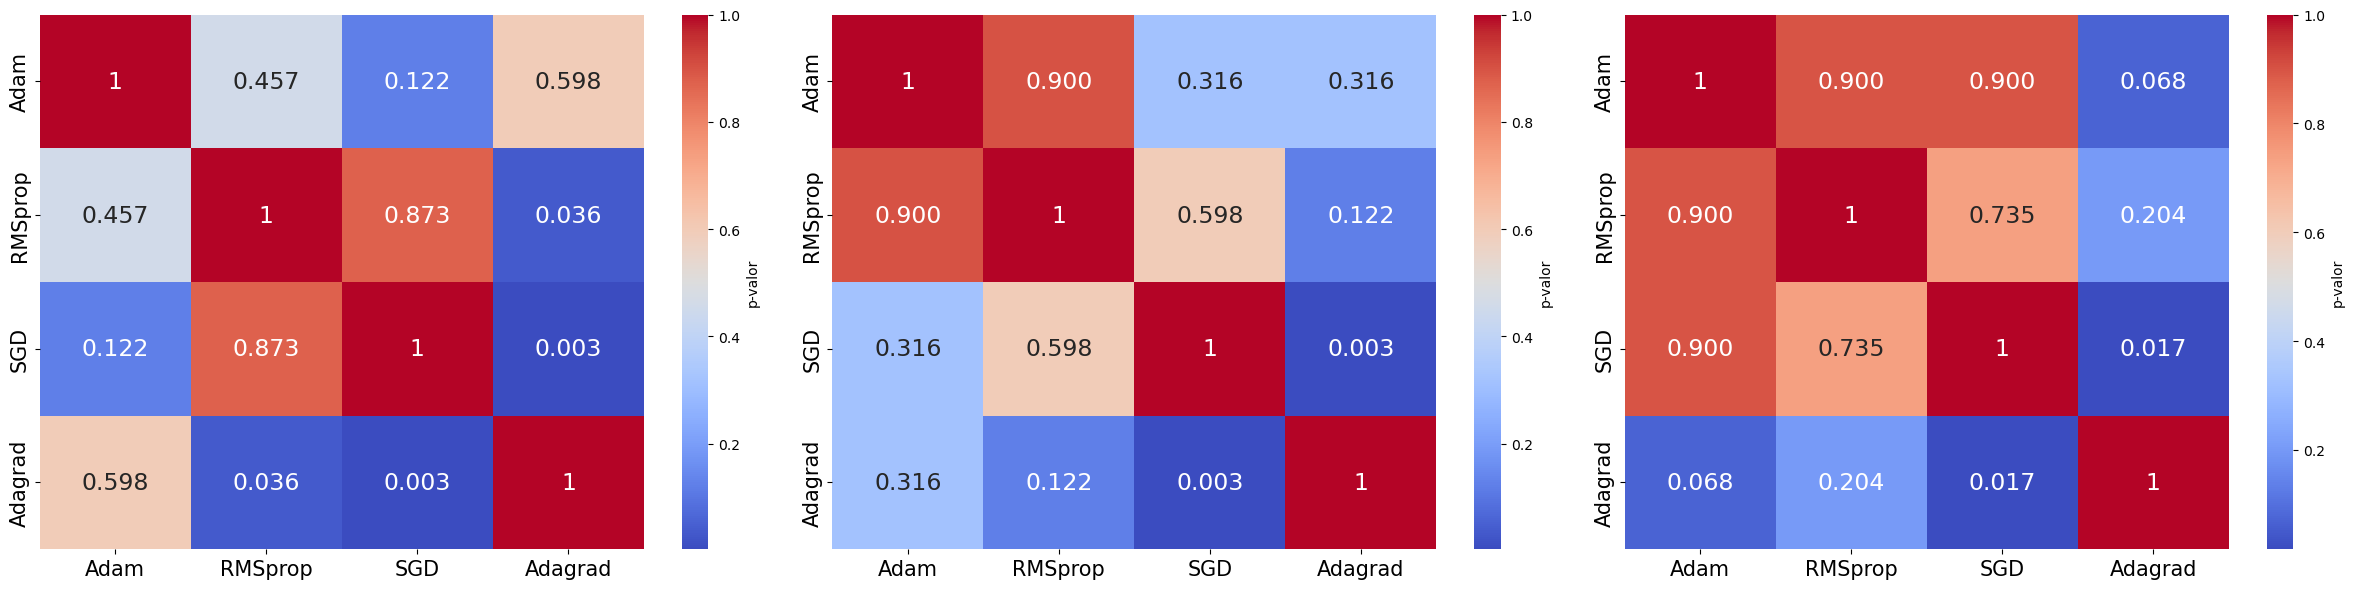

In [193]:
plt.figure(figsize=(24, 6), dpi=100)

# Iterar sobre os modelos
for idx, (_, row) in enumerate(friedman_results.iterrows()):
   if row['Significativo'] == 'Sim':
       # Criar subplot
       plt.subplot(1, 3, idx+1)
       
       # Coletar dados e realizar teste
       optimizer_data = {opt: df_results['MAE'][f"{row['Modelo']}-{opt}"] 
                        for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']}
       posthoc_results = posthoc_nemenyi_friedman(pd.DataFrame(optimizer_data))
       print(posthoc_results)
       # Plotar heatmap
       sns.heatmap(posthoc_results, 
                   annot=[[('1' if val == 1 else f"{val:.3f}") for val in r] 
                          for r in posthoc_results.values],
                   cmap='coolwarm',
                   fmt='',
                   annot_kws={'size': 17},
                   cbar_kws={'label': 'p-valor'})
       
       # plt.title(f'{row["Modelo"]}', fontsize=14)
       plt.xticks(fontsize=15)
       plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig('posthoc_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

## Melhor modelo

Analisando detalhadamente os resultados para cada modelo e considerando todas as métricas (MAE, MSE, RMSE) junto com os testes estatísticos:
* MLP1 (model1) com SGD é o melhor modelo porque:
        Menor MAE: 0.3973 ± 0.0549
        Menor MSE: 1.2067 ± 1.9411
        Menor RMSE: 0.8386 ± 0.7095
Menor desvio padrão no MAE, indicando maior estabilidade

* Teste de Friedman:
    - MLP1: estatística = 14.0400, p = 0.0028512 (mais significativo)
Evidência estatística mais forte de diferenças entre otimizadores

* Comparativo com outros modelos:
    - MLP2-SGD: MAE = 0.4140 ± 0.0669 (maior erro e desvio)
    - MLP3-SGD: MAE = 0.4513 ± 0.1523 (ainda maior erro e desvio)
Tendência de aumento do erro com a complexidade do modelo

* Teste Post-hoc de Nemenyi para MLP1:
    Diferenças mais significativas com Adagrad
    Boa similaridade com RMSprop (p > 0.7)

In [159]:
best_model = 'model1'
best_optimizer = 'SGD'

# best_model = 'model3'
# best_optimizer = 'SGD'

In [ ]:
# Considerando o ultimo fold
# Obter valores reais e previstos do último fold
y_true, y_pred = results[best_model][best_optimizer]['predictions'][-1]

## Curva de aprendizado

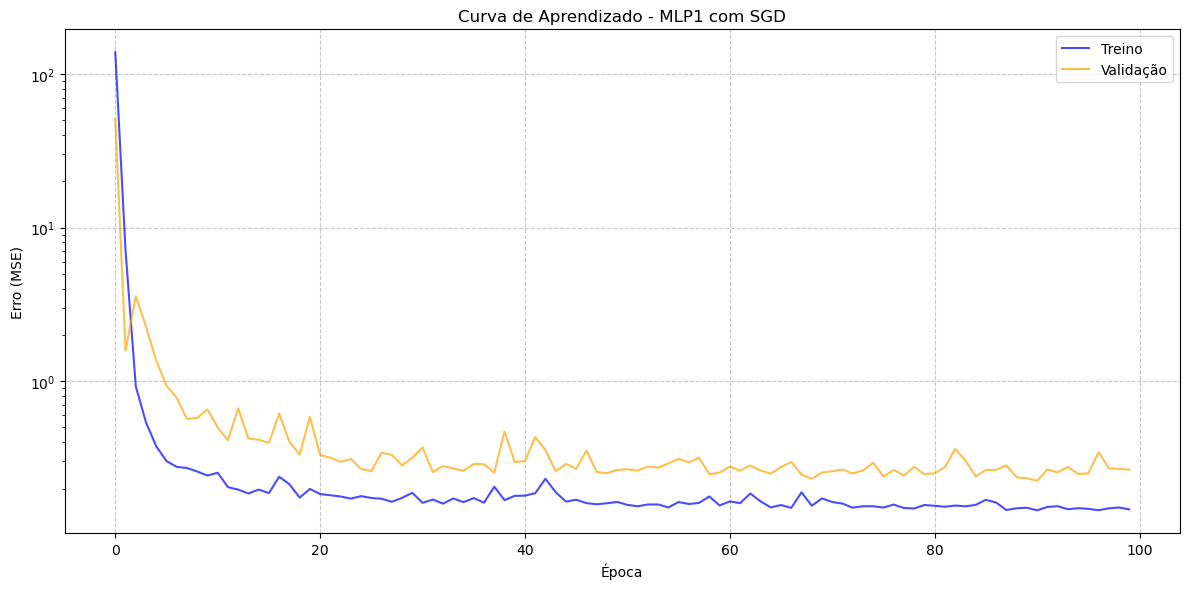

In [183]:
history = results[best_model][best_optimizer]['history']

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Treino', color='blue', alpha=0.7)
plt.plot(history['val_loss'], label='Validação', color='orange', alpha=0.7)
plt.title('Curva de Aprendizado - MLP1 com SGD', fontsize=12)
plt.xlabel('Época', fontsize=10)
plt.ylabel('Erro (MSE)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.yscale('log')  
plt.tight_layout()
# plt.savefig('learning_curve_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

## Previsão vs valor real para o melhor modelo

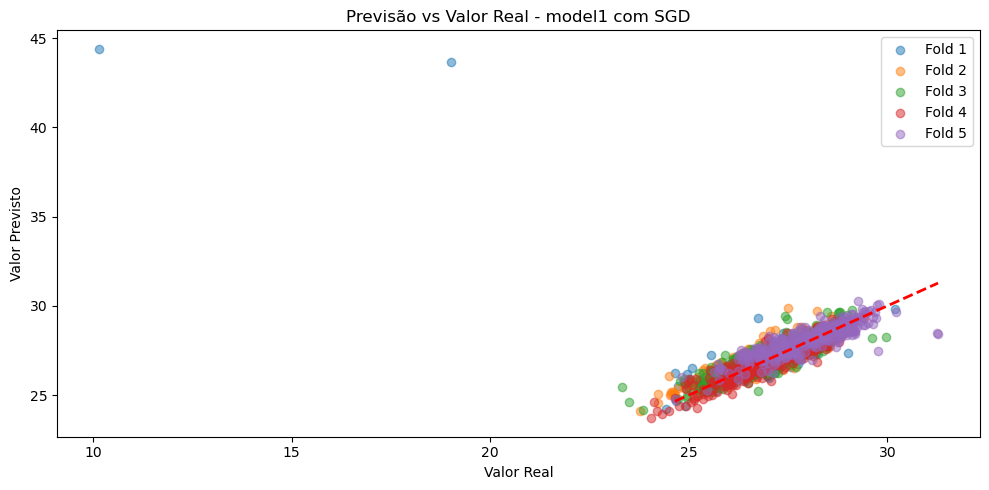

In [184]:
plt.figure(figsize=(10, 5))
for fold, (y_true, y_pred) in enumerate(results[best_model][best_optimizer]['predictions']):
    plt.scatter(y_true, y_pred, alpha=0.5, label=f'Fold {fold+1}')

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title(f'Previsão vs Valor Real - {best_model} com {best_optimizer}')
plt.legend()
plt.tight_layout()
# plt.savefig('best_model_prediction.png')
# plt.close()
plt.show()

## Previsão vs valor real em cada fold

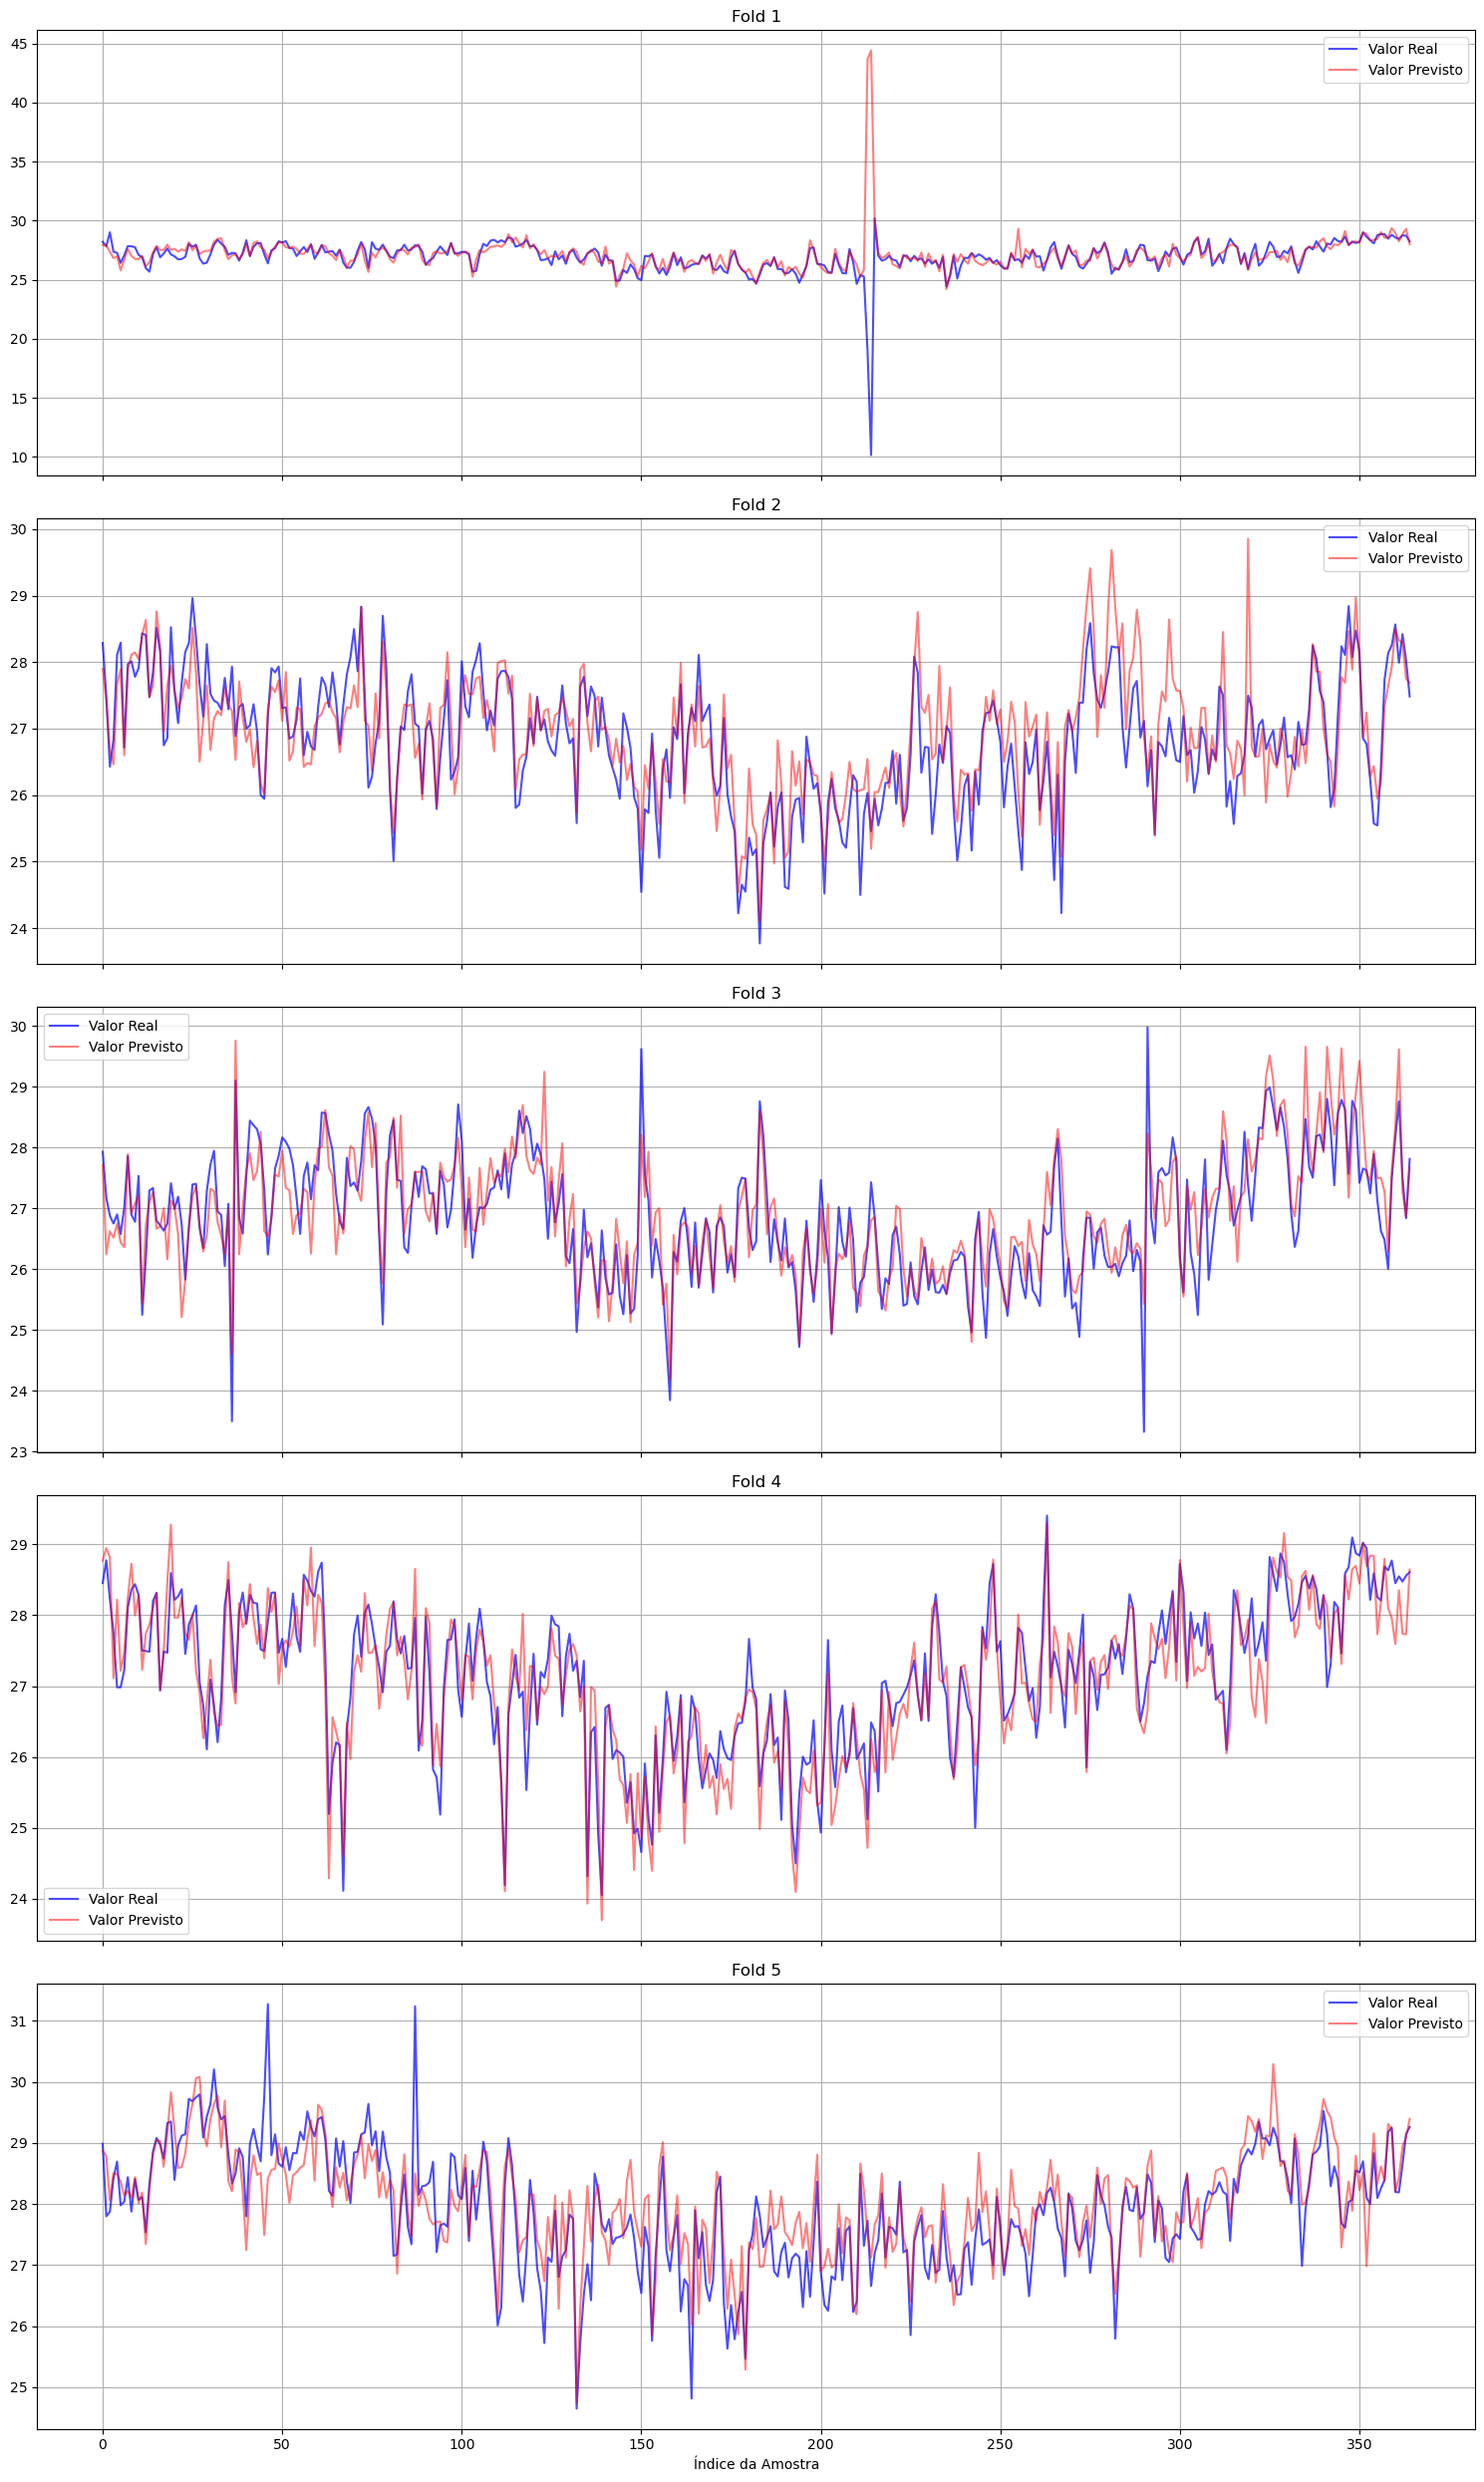

In [190]:
n_folds = len(results[best_model][best_optimizer]['predictions'])
fig, axes = plt.subplots(n_folds, 1, figsize=(15, 5 * n_folds), sharex=True)

for i, (y_true, y_pred) in enumerate(results[best_model][best_optimizer]['predictions']):
    axes[i].plot(y_true, label='Valor Real', color='blue', alpha=0.7)
    axes[i].plot(range(len(y_pred)), y_pred, label='Valor Previsto', color='red', alpha=0.5)
    # axes[i].scatter(range(len(y_pred)), y_pred, label='Valor Previsto', color='red', alpha=0.5)
    axes[i].set_title(f'Fold {i+1}')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Índice da Amostra')
plt.tight_layout()
plt.show()


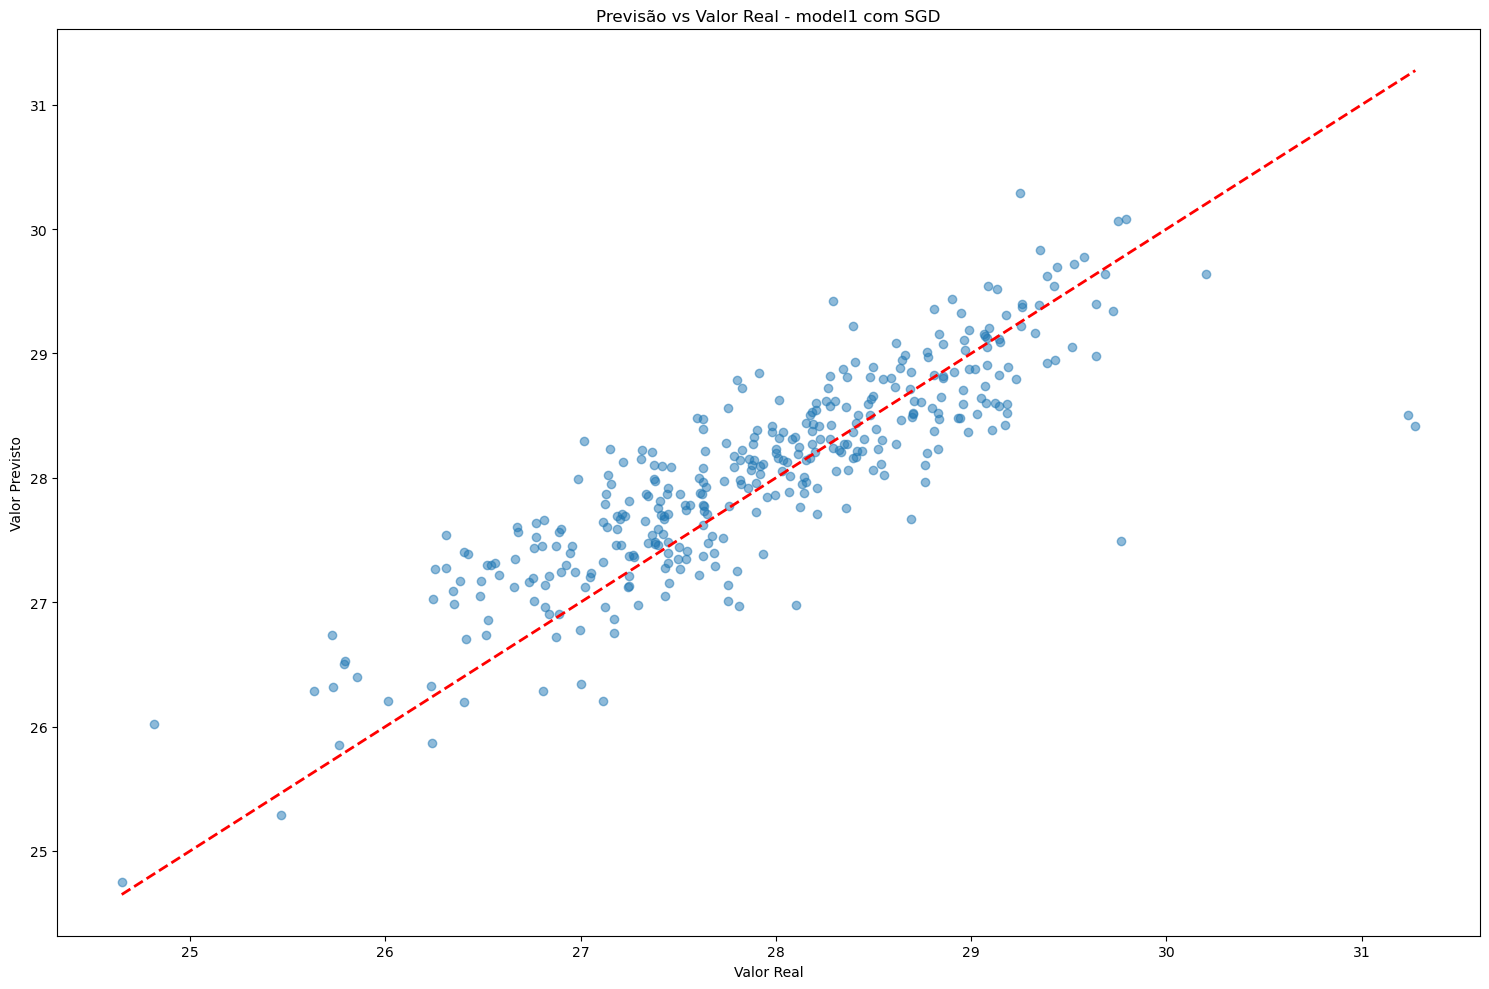

In [186]:
# Último fold 
plt.figure(figsize=(15, 10))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title(f'Previsão vs Valor Real - {best_model} com {best_optimizer}')
plt.tight_layout()
plt.show()

In [172]:
# Criar datas para o período de teste do último fold
dates = pd.date_range(start='2023-09-02', end='2024-08-31', periods=len(y_true))

In [173]:
# Criar DataFrame com as datas
comparison_df = pd.DataFrame({
    'Data': dates,
    'Real': y_true,
    'Previsto': y_pred,
    'Erro': np.abs(y_true - y_pred)
})

In [188]:
comparison_df

Data       Real   Previsto      Erro  Mês   Ano
0   2023-09-02  28.986957  28.873447  0.113509    9  2023
1   2023-09-03  27.800000  28.786041  0.986041    9  2023
2   2023-09-04  27.875000  28.061695  0.186695    9  2023
3   2023-09-05  28.420833  28.506645  0.085812    9  2023
4   2023-09-06  28.695833  28.489220  0.206614    9  2023
..         ...        ...        ...       ...  ...   ...
360 2024-08-27  28.200000  28.206921  0.006921    8  2024
361 2024-08-28  28.191667  28.433338  0.241671    8  2024
362 2024-08-29  28.645833  28.945595  0.299761    8  2024
363 2024-08-30  29.150000  29.089790  0.060210    8  2024
364 2024-08-31  29.262500  29.394829  0.132329    8  2024

[365 rows x 6 columns]

In [174]:
# Adicionar informações temporais
comparison_df['Mês'] = comparison_df['Data'].dt.month
comparison_df['Ano'] = comparison_df['Data'].dt.year

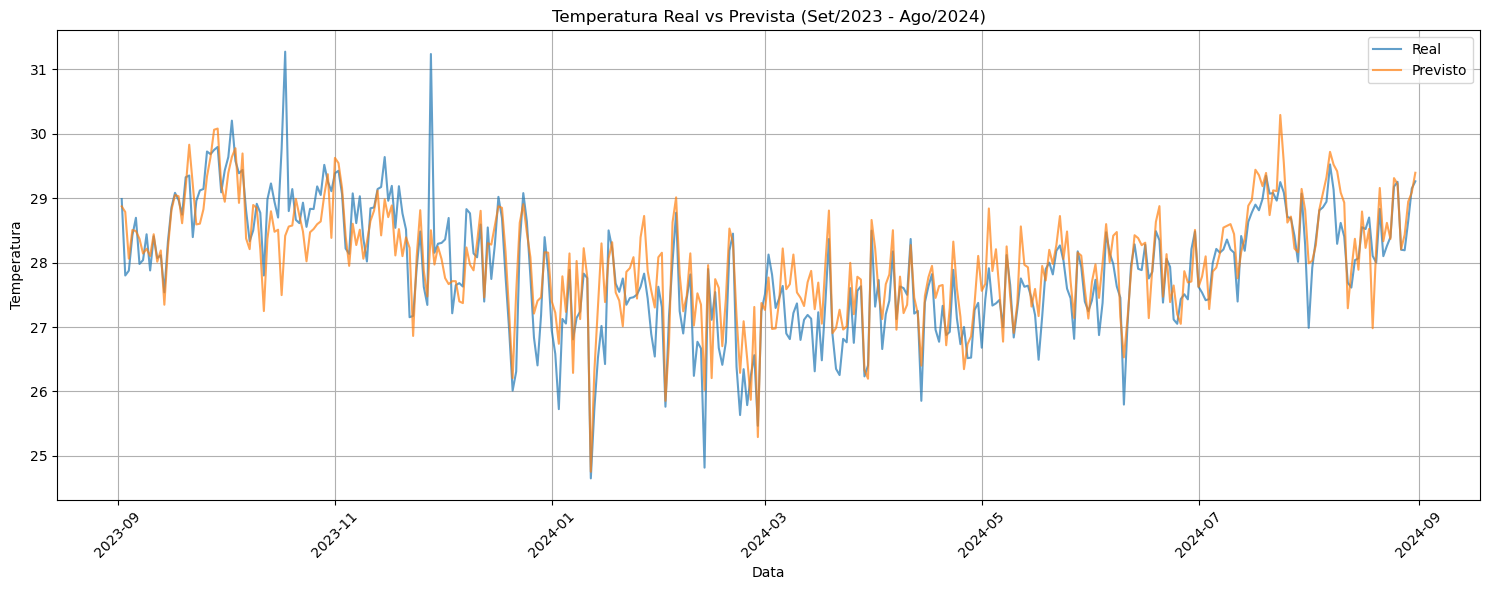

In [176]:
# Visualizações
plt.figure(figsize=(15, 6))
plt.plot(comparison_df['Data'], comparison_df['Real'], label='Real', alpha=0.7)
plt.plot(comparison_df['Data'], comparison_df['Previsto'], label='Previsto', alpha=0.7)
plt.title('Temperatura Real vs Prevista (Set/2023 - Ago/2024)')
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

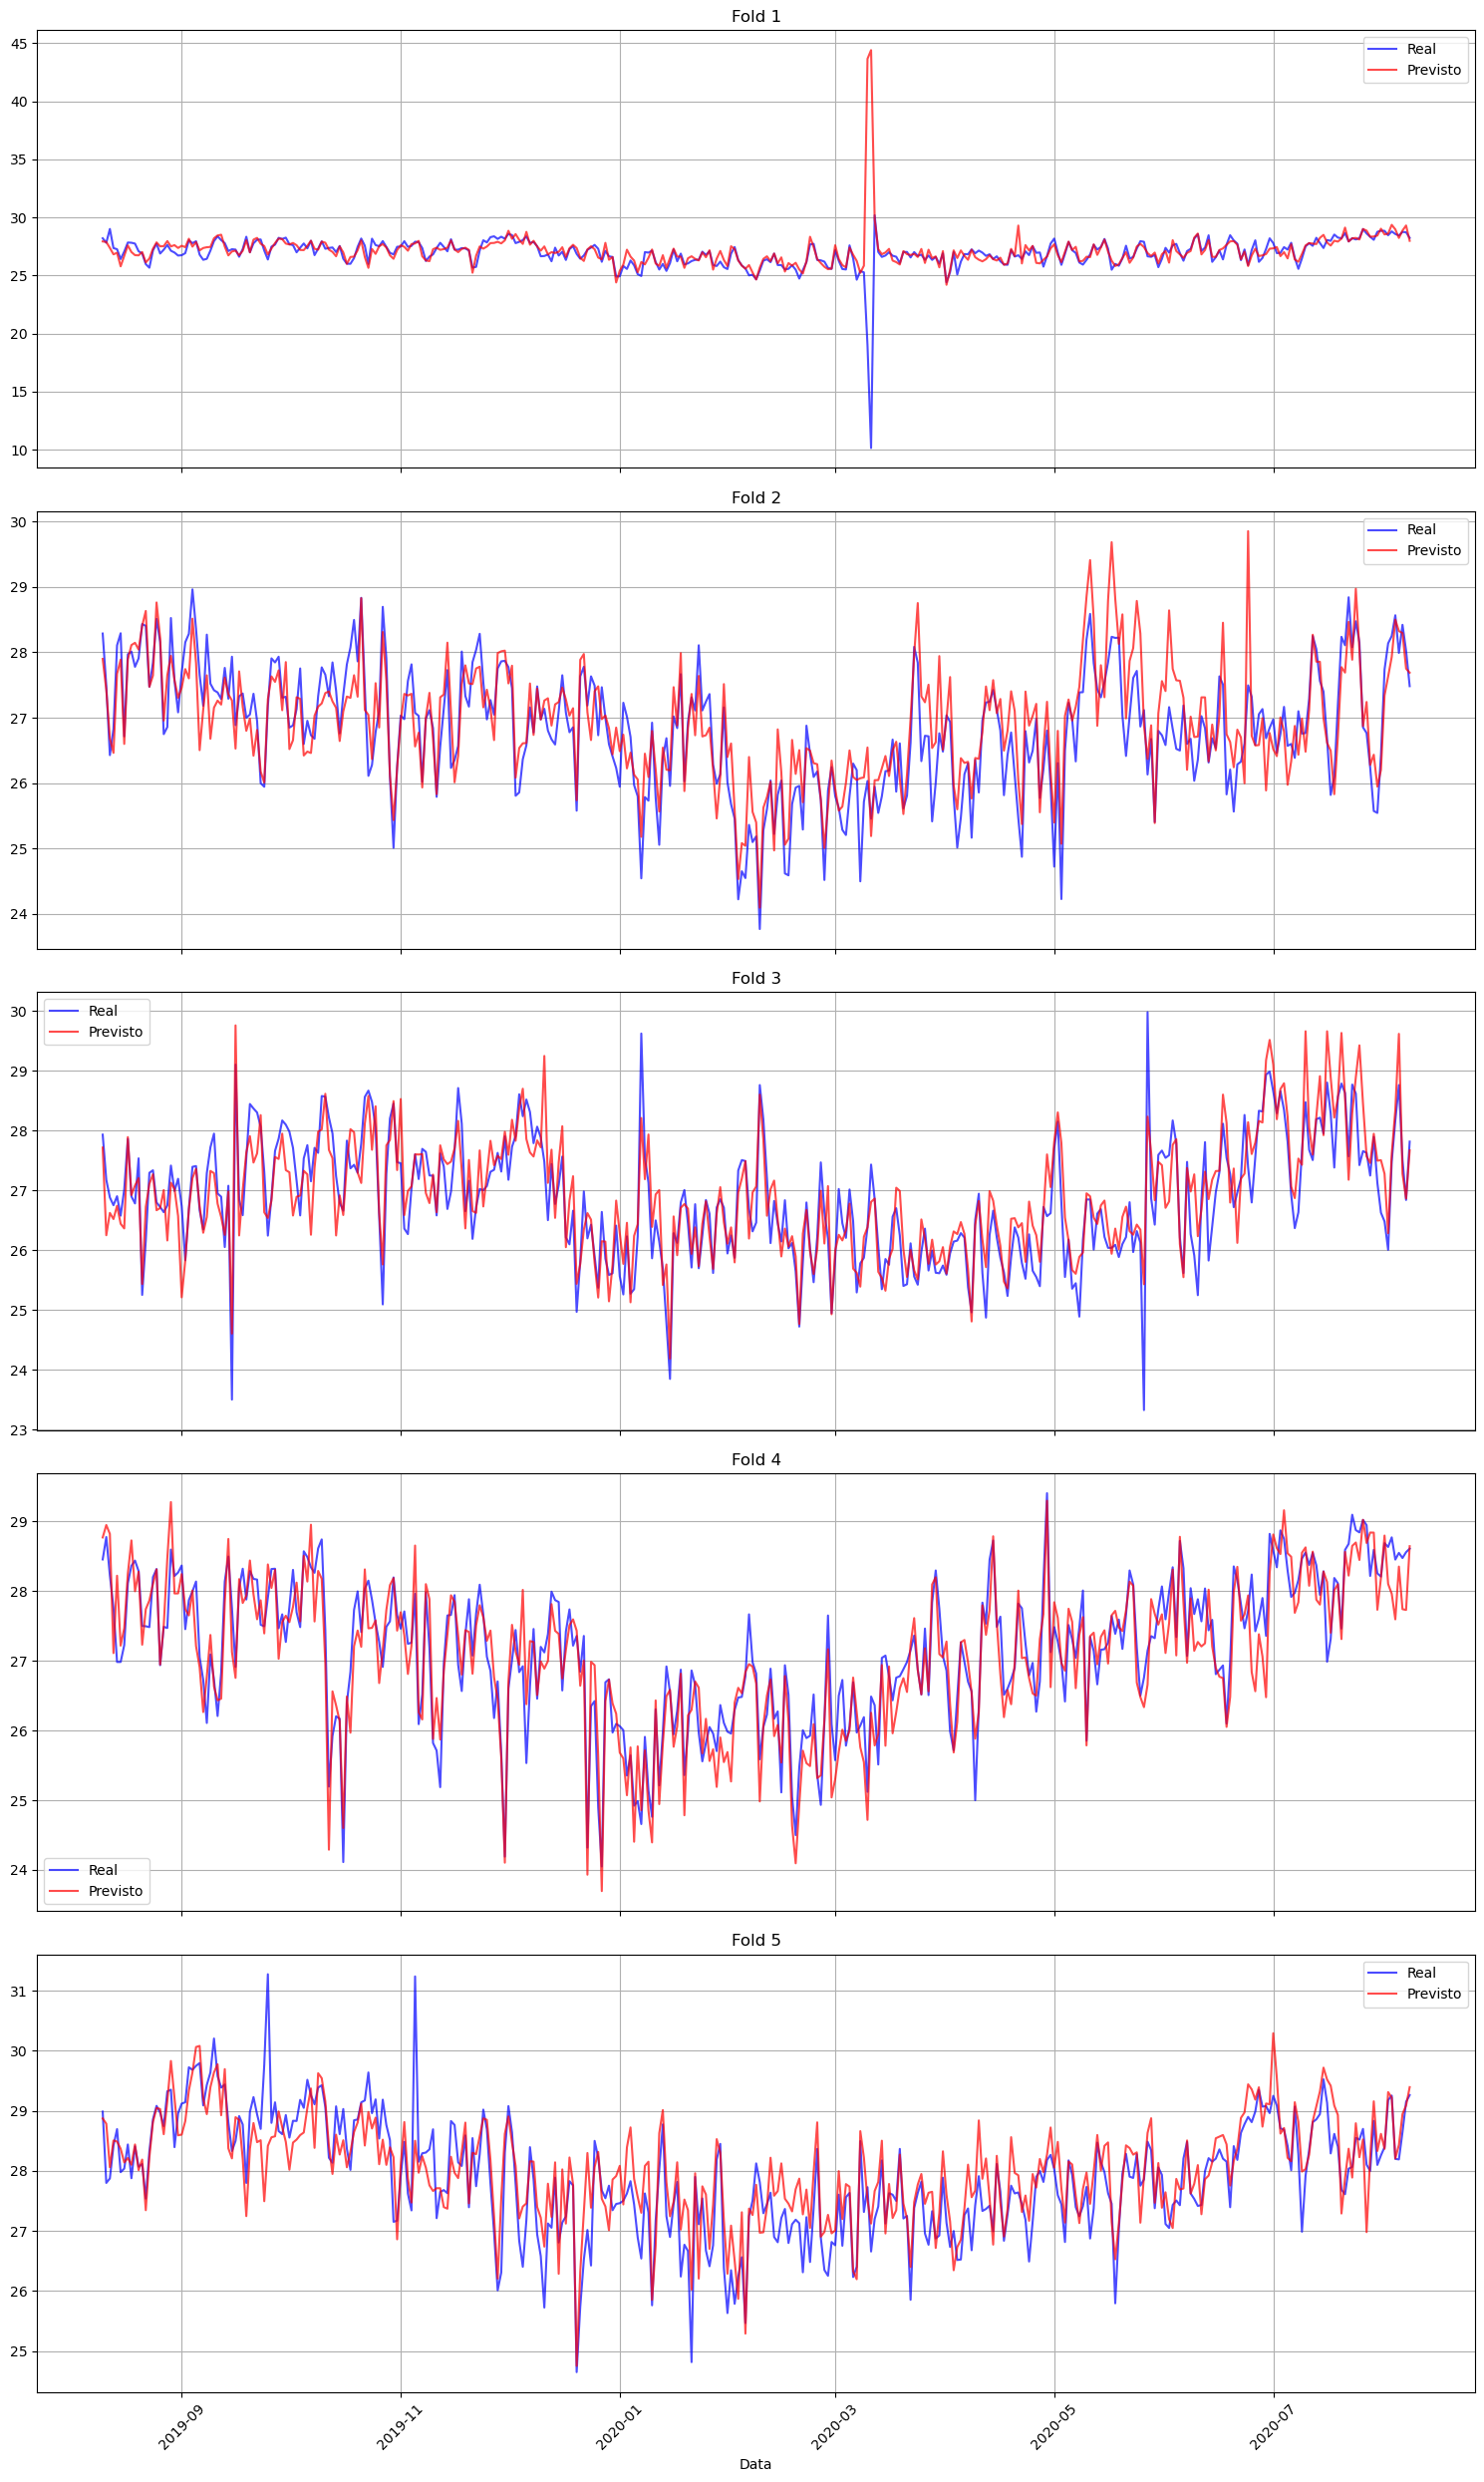

In [194]:
# Loop para gerar gráficos para todos os folds
n_folds = len(results[best_model][best_optimizer]['predictions'])
fig, axes = plt.subplots(n_folds, 1, figsize=(15, 5 * n_folds), sharex=True)

for i, (y_true, y_pred) in enumerate(results[best_model][best_optimizer]['predictions']):
    # Criar datas para o período de teste do fold atual
    start_date = '2019-08-10'  # Altere isso conforme a data do primeiro fold
    dates = pd.date_range(start=start_date, periods=len(y_true))
    
    # Criar DataFrame para o fold atual
    comparison_df = pd.DataFrame({
        'Data': dates,
        'Real': y_true,
        'Previsto': y_pred
    })
    
    # Plotar para o fold atual
    axes[i].plot(comparison_df['Data'], comparison_df['Real'], label='Real', color='blue', alpha=0.7)
    axes[i].plot(comparison_df['Data'], comparison_df['Previsto'], label='Previsto', color='red', alpha=0.7)
    axes[i].set_title(f'Fold {i+1}')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.xlabel('Data')
plt.tight_layout()
plt.show()
